In [1]:
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
pd.set_option("mode.chained_assignment", None)

In [3]:
epl_results = pd.read_csv("D:/Coding/Maths Project/epl_results_14_to_24.csv")
epl_results.head()

,league,season,match_id,isResult,home_id,home_team,home_abbr,away_id,away_team,away_abbr,home_goals,away_goals,home_xG,away_xG,datetime,forecast_win,forecast_draw,forecast_loss
0,EPL,2023/2024,22275,True,92,Burnley,BUR,88,Manchester City,MCI,0,3,0.311032,2.400740,2023-08-11 19:00:00,0.0177,0.0854,0.8969
1,EPL,2023/2024,22276,True,83,Arsenal,ARS,249,Nottingham Forest,NOT,2,1,0.842620,0.966305,2023-08-12 11:30:00,0.2797,0.3363,0.3840
2,EPL,2023/2024,22277,True,73,Bournemouth,BOU,81,West Ham,WHU,1,1,1.510250,1.483400,2023-08-12 14:00:00,0.3559,0.3169,0.3272
3,EPL,2023/2024,22278,True,220,Brighton,BRI,256,Luton,LUT,4,1,4.367480,1.885940,2023-08-12 14:00:00,0.8790,0.0876,0.0334
4,EPL,2023/2024,22279,True,72,Everton,EVE,228,Fulham,FLH,0,1,2.590010,1.581440,2023-08-12 14:00:00,0.6371,0.1989,0.1640


In [4]:
results = epl_results.copy()
results["season_end_year"] = results["season"].str[5:].astype(int)
results["date"] = pd.to_datetime(results["datetime"]).dt.date 
results = results[results.season_end_year > 2019]
results = results[["season_end_year", "match_id",  "date", "home_team", "away_team", "home_goals", "away_goals", "home_xG", "away_xG"]].sort_values(by = "date")
results.head()

,season_end_year,match_id,date,home_team,away_team,home_goals,away_goals,home_xG,away_xG
1520,2020,11643,2019-08-09,Liverpool,Norwich,4,1,2.234560,0.842407
1521,2020,11644,2019-08-10,West Ham,Manchester City,0,5,1.200300,3.183770
1522,2020,11645,2019-08-10,Bournemouth,Sheffield United,1,1,1.340990,1.598640
1523,2020,11646,2019-08-10,Burnley,Southampton,3,0,0.909241,1.087520
1524,2020,11647,2019-08-10,Crystal Palace,Everton,0,0,0.871590,1.224600


In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1900 entries, 1520 to 377
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season_end_year  1900 non-null   int32  
 1   match_id         1900 non-null   int64  
 2   date             1900 non-null   object 
 3   home_team        1900 non-null   object 
 4   away_team        1900 non-null   object 
 5   home_goals       1900 non-null   int64  
 6   away_goals       1900 non-null   int64  
 7   home_xG          1900 non-null   float64
 8   away_xG          1900 non-null   float64
dtypes: float64(2), int32(1), int64(3), object(3)
memory usage: 141.0+ KB


In [6]:
#first two seasons as training data to set up ELO
ELO_data = results[results["season_end_year"] <= 2021]
ELO_data.head()

,season_end_year,match_id,date,home_team,away_team,home_goals,away_goals,home_xG,away_xG
1520,2020,11643,2019-08-09,Liverpool,Norwich,4,1,2.234560,0.842407
1521,2020,11644,2019-08-10,West Ham,Manchester City,0,5,1.200300,3.183770
1522,2020,11645,2019-08-10,Bournemouth,Sheffield United,1,1,1.340990,1.598640
1523,2020,11646,2019-08-10,Burnley,Southampton,3,0,0.909241,1.087520
1524,2020,11647,2019-08-10,Crystal Palace,Everton,0,0,0.871590,1.224600


In [7]:
#expected result based on ELO before game
def expected_result_elo(home_elo, away_elo):
    E_home = 1/(10**((away_elo - home_elo)/400)+1)
    E_away = 1/(10**((home_elo - away_elo)/400)+1)
    
    return [E_home, E_away]

In [8]:
#actual result based on goals scored
def actual_result(home_goals, away_goals):
    if home_goals < away_goals:
        home_result = 0
        away_result = 1
    elif home_goals > away_goals:
        home_result = 1
        away_result = 0
    else:
        home_result = 0.5
        away_result = 0.5
    
    return [home_result, away_result]

In [9]:
#function to update ELO after matches
def update_elo(home_elo, away_elo, home_goals, away_goals, k = 32):
    
    home_result, away_result = actual_result(home_goals, away_goals)
    E_home, E_away = expected_result_elo(home_elo, away_elo)
    
    new_home_elo = home_elo+k*(home_result - E_home)
    new_away_elo = away_elo+k*(away_result - E_away)
    
    return new_home_elo, new_away_elo

In [10]:
#initialising ELO
current_elo = {}
home_teams = []
away_teams = []
home_elos = []
away_elos = []
season_end_years = []
dates = []

for idx, row in results.iterrows():
    
    home_team = row["home_team"]
    away_team = row["away_team"]
    home_goals = row["home_goals"]
    away_goals = row["away_goals"]
    season_end_year = row["season_end_year"]
    
    if home_team not in current_elo.keys():
        if season_end_year == 2020:
            current_elo[home_team] = 1500
        else:
            current_elo[home_team] = 1400
        
    if away_team not in current_elo.keys():
        if season_end_year == 2020:
            current_elo[away_team] = 1500
        else:
            current_elo[away_team] = 1400
        
    home_elo = current_elo[home_team]
    away_elo = current_elo[away_team]
    
    home_teams.append(home_team)
    away_teams.append(away_team)
    home_elos.append(home_elo)
    away_elos.append(away_elo)
    season_end_years.append(season_end_year)
    dates.append(row["date"])
    
    new_home_elo, new_away_elo = update_elo(home_elo, away_elo, home_goals, away_goals, k=10)
    
    current_elo[home_team] = new_home_elo
    current_elo[away_team] = new_away_elo

ELO_match_results = pd.DataFrame({"home_team": home_teams, "away_team": away_teams, "home_elo": home_elos, "away_elo": away_elos, "season_end_year":season_end_years, "dates": dates})
ELO = pd.DataFrame(current_elo.items(), columns = ["Club", "ELO"])
ELO_match_results[ELO_match_results["home_team"] == "Arsenal"].head()

,home_team,away_team,home_elo,away_elo,season_end_year,dates
16,Arsenal,Burnley,1505.000000,1505.000000,2020,2019-08-17
38,Arsenal,Tottenham,1504.997930,1499.784267,2020,2019-09-01
59,Arsenal,Aston Villa,1504.640662,1490.566095,2020,2019-09-22
77,Arsenal,Bournemouth,1509.300519,1505.213586,2020,2019-10-06
97,Arsenal,Crystal Palace,1508.966128,1504.845129,2020,2019-10-27


In [11]:
ELO.sort_values(by = "ELO", ascending=False)

,Club,ELO
3,Manchester City,1719.533468
0,Liverpool,1658.211599
17,Arsenal,1653.209616
18,Manchester United,1567.433108
12,Tottenham,1553.890156
19,Chelsea,1547.598362
16,Newcastle United,1540.233227
13,Aston Villa,1538.140959
11,Brighton,1494.356998
2,West Ham,1480.628216


In [12]:
#training logistic regression model
#getting results from after ELO training
matches = results[results.season_end_year > 2021]

#inserting home and away elo rankings calculated above
matches = pd.merge(matches, ELO_match_results, on = ["home_team", "away_team", "season_end_year"])

#calculating the difference between elo ratings with respect to home side
matches["elo_diff"] = matches["home_elo"]-matches["away_elo"]

#creating binary variable for which team won
matches["home_win"] = (matches["home_goals"] > matches["away_goals"]).astype(int)
matches["away_win"] = (matches["away_goals"] > matches["home_goals"]).astype(int)

#getting training data, the 2021-22 and 2022-23 seasons
training_matches = matches[matches.season_end_year <= 2023]
training_matches[training_matches["home_team"] == "Arsenal"].head()


,season_end_year,match_id,date,home_team,away_team,home_goals,away_goals,home_xG,away_xG,home_elo,away_elo,dates,elo_diff,home_win,away_win
18,2022,16394,2021-08-22,Arsenal,Chelsea,0,2,0.630099,3.641320,1524.311284,1558.143883,2021-08-22,-33.832599,0,1
35,2022,16407,2021-09-11,Arsenal,Norwich,1,0,2.685150,0.577292,1516.130960,1403.320881,2021-09-11,112.810079,1,0
58,2022,16434,2021-09-26,Arsenal,Tottenham,3,1,1.444990,0.980166,1523.614442,1533.430253,2021-09-26,-9.815811,1,0
79,2022,16446,2021-10-18,Arsenal,Crystal Palace,2,2,1.743600,0.492239,1528.045804,1457.474209,2021-10-18,70.571594,0,0
80,2022,16456,2021-10-22,Arsenal,Aston Villa,3,1,3.498400,1.410880,1527.043938,1473.328361,2021-10-22,53.715577,1,0


In [13]:
#setting up regression for home win probabilities
#X is ELO difference
X = np.array(training_matches["elo_diff"]).reshape(-1,1)
#y is whether home team won or not
y_home = np.array(training_matches["home_win"]).reshape(-1,1)
#model
from sklearn.linear_model import LogisticRegression
home_model = LogisticRegression(solver = "liblinear", random_state = 0)
home_model.fit(X, y_home)
print("Model Intercept:", home_model.intercept_)
print("Model Slope:", home_model.coef_)

Model Intercept: [-0.19325223]
Model Slope: [[0.00764348]]


d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: xlabel='elo_diff', ylabel='home_win'>

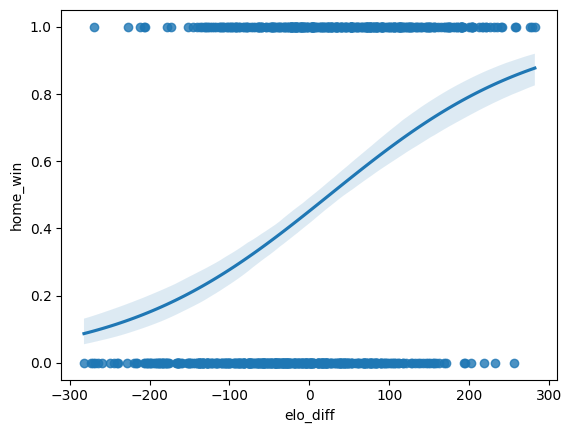

In [14]:
import seaborn as sns
sns.regplot(x="elo_diff", y = "home_win", data=training_matches, logistic=True)

In [15]:
#setting up regression for away win probabilities
#X is ELO difference
X = np.array(training_matches["elo_diff"]).reshape(-1,1)

#y is whether away team won or not
y_away = np.array(training_matches["away_win"]).reshape(-1,1)

#model
away_model = LogisticRegression(solver = "liblinear", random_state = 0)
away_model.fit(X, y_away)

#model information
print("Model Intercept:", away_model.intercept_)
print("Model Slope:", away_model.coef_)

Model Intercept: [-0.90186476]
Model Slope: [[-0.00787628]]


d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: xlabel='elo_diff', ylabel='away_win'>

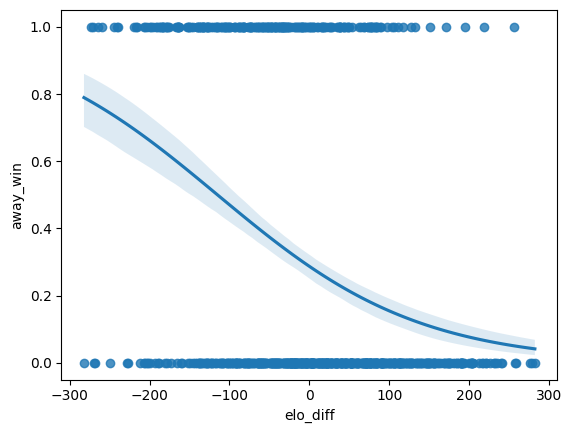

In [16]:
import seaborn as sns
sns.regplot(x="elo_diff", y = "away_win", data=training_matches, logistic=True)

In [17]:
#fitting our model to last season's data
test_matches = matches[matches.season_end_year == 2024].reset_index(drop = True)

h_win_prob = pd.DataFrame(home_model.predict_proba(np.array(test_matches["elo_diff"]).reshape(-1,1)))[1]
a_win_prob = pd.DataFrame(away_model.predict_proba(np.array(test_matches["elo_diff"]).reshape(-1,1)))[1]
d_prob = 1 - (h_win_prob + a_win_prob)

win_probs = pd.DataFrame({"home_win_prob":h_win_prob, "away_win_prob":a_win_prob, "draw_prob":d_prob})

test_matches = pd.concat([test_matches, win_probs], axis = 1)

test_matches.head()

,season_end_year,match_id,date,home_team,away_team,home_goals,away_goals,home_xG,away_xG,home_elo,away_elo,dates,elo_diff,home_win,away_win,home_win_prob,away_win_prob,draw_prob
0,2024,22275,2023-08-11,Burnley,Manchester City,0,3,0.311032,2.400740,1441.850585,1693.675010,2023-08-11,-251.824425,0,1,0.107353,0.746792,0.145855
1,2024,22276,2023-08-12,Arsenal,Nottingham Forest,2,1,0.842620,0.966305,1603.011245,1408.365955,2023-08-12,194.645290,1,0,0.784911,0.080546,0.134543
2,2024,22277,2023-08-12,Bournemouth,West Ham,1,1,1.510250,1.483400,1430.229556,1472.627797,2023-08-12,-42.398241,0,0,0.373479,0.361716,0.264806
3,2024,22278,2023-08-12,Brighton,Luton,4,1,4.367480,1.885940,1512.610575,1400.000000,2023-08-12,112.610575,1,0,0.660940,0.143218,0.195842
4,2024,22279,2023-08-12,Everton,Fulham,0,1,2.590010,1.581440,1442.947156,1424.992479,2023-08-12,17.954677,0,1,0.486000,0.260517,0.253483


In [18]:
#computing ELO-based expected points (xPELO)
def ex_points(win_prob, draw_prob):
    return(3*win_prob + draw_prob)

#computing actual points
def actual_points(GF, GA):
    
    if GF > GA:  x = 3
    elif GF < GA: x = 0
    else: x = 1
    
    return x

In [19]:
#calculating xPELO
test_matches["home_xPELO"] = ex_points(test_matches["home_win_prob"], test_matches["draw_prob"])
test_matches["away_xPELO"] = ex_points(test_matches["away_win_prob"], test_matches["draw_prob"])

#calculating points
test_matches["home_goals"] = test_matches["home_goals"].astype(int)
test_matches["away_goals"] = test_matches["away_goals"].astype(int)
test_matches["home_points"] = test_matches.apply(lambda x: actual_points(x["home_goals"], x["away_goals"]), axis = 1)
test_matches["away_points"] = test_matches.apply(lambda x: actual_points(x["away_goals"], x["home_goals"]), axis = 1)
test_matches.head()

,season_end_year,match_id,date,home_team,away_team,home_goals,away_goals,home_xG,away_xG,home_elo,...,elo_diff,home_win,away_win,home_win_prob,away_win_prob,draw_prob,home_xPELO,away_xPELO,home_points,away_points
0,2024,22275,2023-08-11,Burnley,Manchester City,0,3,0.311032,2.400740,1441.850585,...,-251.824425,0,1,0.107353,0.746792,0.145855,0.467914,2.386231,0,3
1,2024,22276,2023-08-12,Arsenal,Nottingham Forest,2,1,0.842620,0.966305,1603.011245,...,194.645290,1,0,0.784911,0.080546,0.134543,2.489275,0.376182,3,0
2,2024,22277,2023-08-12,Bournemouth,West Ham,1,1,1.510250,1.483400,1430.229556,...,-42.398241,0,0,0.373479,0.361716,0.264806,1.385241,1.349953,1,1
3,2024,22278,2023-08-12,Brighton,Luton,4,1,4.367480,1.885940,1512.610575,...,112.610575,1,0,0.660940,0.143218,0.195842,2.178662,0.625496,3,0
4,2024,22279,2023-08-12,Everton,Fulham,0,1,2.590010,1.581440,1442.947156,...,17.954677,0,1,0.486000,0.260517,0.253483,1.711482,1.035035,0,3


In [20]:
teams = test_matches["home_team"].unique()

In [21]:
xPELO = []
xPELO_home = []
xPELO_away = []
points = []
points_home = []
points_away = []
gd = []
gd_home = []
gd_away = []

for team in teams:
    
    xpoints_home = test_matches[test_matches["home_team"] == team]["home_xPELO"].sum()
    xpoints_away = test_matches[test_matches["away_team"] == team]["away_xPELO"].sum()
    xpoints = xpoints_home + xpoints_away
    
    points_h = test_matches[test_matches["home_team"] == team]["home_points"].sum()
    points_a = test_matches[test_matches["away_team"] == team]["away_points"].sum()
    points_t = points_h + points_a
    
    gd_h = (test_matches[test_matches["home_team"] == team]["home_goals"] - test_matches[test_matches["home_team"] == team]["away_goals"]).sum()
    gd_a= (test_matches[test_matches["away_team"] == team]["away_goals"] - test_matches[test_matches["away_team"] == team]["home_goals"]).sum()
    gd_t = gd_h + gd_a
    
    xPELO.append(xpoints)
    xPELO_home.append(xpoints_home)
    xPELO_away.append(xpoints_away)
    points.append(points_t)
    points_home.append(points_h)
    points_away.append(points_a)
    gd.append(gd_t)
    gd_home.append(gd_h)
    gd_away.append(gd_a)
    

In [22]:
dict = {"Squad": teams, "Points": points, "Home Points": points_home, "Away Points": points_away, "GD":gd, "xPELO": xPELO, "Home xPELO": xPELO_home, "Away xPELO": xPELO_away}

expected_points = pd.DataFrame(dict).sort_values("GD", ascending = False)

expected_points["Points Rank"] = expected_points["Points"].rank(ascending = False, method = "first")
expected_points["xPELO Rank"] = expected_points["xPELO"].rank(ascending = False, method = "first")

expected_points[["Squad", "xPELO Rank", "Points Rank", "xPELO", "Points", "GD"]].sort_values("xPELO Rank", ascending=True).reset_index(drop = True)

,Squad,xPELO Rank,Points Rank,xPELO,Points,GD
0,Manchester City,1.0,1.0,88.751131,91,62
1,Liverpool,2.0,3.0,81.922851,82,45
2,Arsenal,3.0,2.0,76.295034,89,62
3,Manchester United,4.0,8.0,67.334717,60,-1
4,Tottenham,5.0,5.0,64.632391,66,13
5,Newcastle United,6.0,7.0,61.005098,60,23
6,Aston Villa,7.0,4.0,58.551446,68,15
7,Chelsea,8.0,6.0,57.107700,63,14
8,Brighton,9.0,11.0,55.540451,48,-7
9,West Ham,10.0,9.0,49.714262,52,-14


Goal Based ELO

In [23]:
#function to update ELO after matches based on goal difference
def update_elo_g(home_elo, away_elo, home_goals, away_goals, k0, lambda0):
    
    home_result, away_result = actual_result(home_goals, away_goals)
    E_home, E_away = expected_result_elo(home_elo, away_elo)
    
    goal_diff = abs(home_goals - away_goals)
    
    k = k0*(1+goal_diff)**lambda0
    
    new_home_elo = home_elo+k*(home_result - E_home)
    new_away_elo = away_elo+k*(away_result - E_away)
    
    return new_home_elo, new_away_elo

In [24]:
#calculating Elog
current_elo = {}
home_teams = []
away_teams = []
home_elos = []
away_elos = []
season_end_years = []

for idx, row in results.iterrows():
    
    home_team = row["home_team"]
    away_team = row["away_team"]
    home_goals = row["home_goals"]
    away_goals = row["away_goals"]
    season_end_year = row["season_end_year"]
    
    if home_team not in current_elo.keys():
        if season_end_year == 2020:
            current_elo[home_team] = 1500
        else:
            current_elo[home_team] = 1400
        
    if away_team not in current_elo.keys():
        if season_end_year == 2020:
            current_elo[away_team] = 1500
        else:
            current_elo[away_team] = 1400
        
    home_elo = current_elo[home_team]
    away_elo = current_elo[away_team]
    
    home_teams.append(home_team)
    away_teams.append(away_team)
    home_elos.append(home_elo)
    away_elos.append(away_elo)
    season_end_years.append(season_end_year)
    
    new_home_elo, new_away_elo = update_elo_g(home_elo, away_elo, home_goals, away_goals, k0 = 10, lambda0 = 1)
    
    current_elo[home_team] = new_home_elo
    current_elo[away_team] = new_away_elo

ELO_match_results_g = pd.DataFrame({"home_team": home_teams, "away_team": away_teams, "home_elo": home_elos, "away_elo": away_elos, "season_end_year":season_end_years})

#training logistic regression model
#getting results from after ELO training
matches_g = results[results.season_end_year > 2021]

#inserting home and away elo rankings calculated above
matches_g = pd.merge(matches_g, ELO_match_results_g, on = ["home_team", "away_team", "season_end_year"])

#calculating the difference between elo ratings with respect to home side
matches_g["elo_diff_g"] = matches_g["home_elo"]-matches_g["away_elo"]

#creating binary variable for which team won
matches_g["home_win"] = (matches_g["home_goals"] > matches_g["away_goals"]).astype(int)
matches_g["away_win"] = (matches_g["away_goals"] > matches_g["home_goals"]).astype(int)

#getting training data, the 2021-22 and 2022-23 seasons
training_matches_g = matches_g[matches_g.season_end_year <= 2023]

#setting up regression for home win probabilities
#X is ELO difference
X_g = np.array(training_matches_g["elo_diff_g"]).reshape(-1,1)
#y is whether home team won or not
y_home_g = np.array(training_matches_g["home_win"]).reshape(-1,1)
#model
from sklearn.linear_model import LogisticRegression
home_model_g = LogisticRegression(solver = "liblinear", random_state = 0)
home_model_g.fit(X_g, y_home_g)

#setting up regression for away win probabilities
#X is ELO difference
X_g = np.array(training_matches_g["elo_diff_g"]).reshape(-1,1)

#y is whether away team won or not
y_away_g = np.array(training_matches_g["away_win"]).reshape(-1,1)

#model
away_model_g = LogisticRegression(solver = "liblinear", random_state = 0)
away_model_g.fit(X_g, y_away_g)

#fitting our model to last season's data
test_matches_g = matches_g[matches_g.season_end_year == 2024].reset_index(drop = True)

h_win_prob = pd.DataFrame(home_model_g.predict_proba(np.array(test_matches["elo_diff"]).reshape(-1,1)))[1]
a_win_prob = pd.DataFrame(away_model_g.predict_proba(np.array(test_matches["elo_diff"]).reshape(-1,1)))[1]
d_prob = 1 - (h_win_prob + a_win_prob)

win_probs = pd.DataFrame({"home_win_prob":h_win_prob, "away_win_prob":a_win_prob, "draw_prob":d_prob})

test_matches_g = pd.concat([test_matches_g, win_probs], axis = 1)

#calculating xPELOg
test_matches_g["home_xPELOg"] = ex_points(test_matches_g["home_win_prob"], test_matches_g["draw_prob"])
test_matches_g["away_xPELOg"] = ex_points(test_matches_g["away_win_prob"], test_matches_g["draw_prob"])

#calculating points
test_matches_g["home_goals"] = test_matches_g["home_goals"].astype(int)
test_matches_g["away_goals"] = test_matches_g["away_goals"].astype(int)
test_matches_g["home_points"] = test_matches_g.apply(lambda x: actual_points(x["home_goals"], x["away_goals"]), axis = 1)
test_matches_g["away_points"] = test_matches_g.apply(lambda x: actual_points(x["away_goals"], x["home_goals"]), axis = 1)

#simming the season
xPELO_g = []
xPELO_home_g = []
xPELO_away_g = []

for team in teams:
    
    xpoints_home = test_matches_g[test_matches_g["home_team"] == team]["home_xPELOg"].sum()
    xpoints_away = test_matches_g[test_matches_g["away_team"] == team]["away_xPELOg"].sum()
    xpoints = xpoints_home + xpoints_away
    
    xPELO_g.append(xpoints)
    xPELO_home_g.append(xpoints_home)
    xPELO_away_g.append(xpoints_away)
    
dict = {"Squad": teams, "xPELO_g": xPELO_g, "Home xPELO_g": xPELO_home_g, "Away xPELO_g": xPELO_away_g}

expected_points_g = pd.DataFrame(dict)

expected_points_g["xPELO_g Rank"] = expected_points_g["xPELO_g"].rank(ascending = False)

expected_points_g[["Squad", "xPELO_g Rank", "xPELO_g"]].sort_values("xPELO_g Rank", ascending=True).reset_index(drop = True)

d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Squad,xPELO_g Rank,xPELO_g
0,Manchester City,1.0,75.808773
1,Liverpool,2.0,70.885891
2,Arsenal,3.0,67.037051
3,Manchester United,4.0,61.261040
4,Tottenham,5.0,59.541474
5,Newcastle United,6.0,57.273884
6,Aston Villa,7.0,55.779630
7,Chelsea,8.0,54.864649
8,Brighton,9.0,53.914526
9,West Ham,10.0,50.330496


xG based ELO

In [25]:
#calculating Elog
current_elo = {}
home_teams = []
away_teams = []
home_elos = []
away_elos = []
season_end_years = []

for idx, row in results.iterrows():
    
    home_team = row["home_team"]
    away_team = row["away_team"]
    home_goals = row["home_xG"]
    away_goals = row["away_xG"]
    season_end_year = row["season_end_year"]
    
    if home_team not in current_elo.keys():
        if season_end_year == 2020:
            current_elo[home_team] = 1500
        else:
            current_elo[home_team] = 1400
        
    if away_team not in current_elo.keys():
        if season_end_year == 2020:
            current_elo[away_team] = 1500
        else:
            current_elo[away_team] = 1400
        
    home_elo = current_elo[home_team]
    away_elo = current_elo[away_team]
    
    home_teams.append(home_team)
    away_teams.append(away_team)
    home_elos.append(home_elo)
    away_elos.append(away_elo)
    season_end_years.append(season_end_year)
    
    new_home_elo, new_away_elo = update_elo_g(home_elo, away_elo, home_goals, away_goals, k0 = 10, lambda0 = 1)
    
    current_elo[home_team] = new_home_elo
    current_elo[away_team] = new_away_elo

ELO_match_results_xg = pd.DataFrame({"home_team": home_teams, "away_team": away_teams, "home_elo": home_elos, "away_elo": away_elos, "season_end_year":season_end_years})

#training logistic regression model
#getting results from after ELO training
matches_xg = results[results.season_end_year > 2021]

#inserting home and away elo rankings calculated above
matches_xg = pd.merge(matches_xg, ELO_match_results_xg, on = ["home_team", "away_team", "season_end_year"])

#calculating the difference between elo ratings with respect to home side
matches_xg["elo_diff_xg"] = matches_xg["home_elo"]-matches_xg["away_elo"]

#creating binary variable for which team won
matches_xg["home_win"] = (matches_xg["home_goals"] > matches_xg["away_goals"]).astype(int)
matches_xg["away_win"] = (matches_xg["away_goals"] > matches_xg["home_goals"]).astype(int)

#getting training data, the 2021-22 and 2022-23 seasons
training_matches_xg = matches_xg[matches_xg.season_end_year <= 2023]

#setting up regression for home win probabilities
#X is ELO difference
X_xg = np.array(training_matches_xg["elo_diff_xg"]).reshape(-1,1)
#y is whether home team won or not
y_home_xg = np.array(training_matches_xg["home_win"]).reshape(-1,1)
#model
from sklearn.linear_model import LogisticRegression
home_model_xg = LogisticRegression(solver = "liblinear", random_state = 0)
home_model_xg.fit(X_xg, y_home_xg)

#setting up regression for away win probabilities
#X is ELO difference
X_xg = np.array(training_matches_xg["elo_diff_xg"]).reshape(-1,1)

#y is whether away team won or not
y_away_xg = np.array(training_matches_xg["away_win"]).reshape(-1,1)

#model
away_model_xg = LogisticRegression(solver = "liblinear", random_state = 0)
away_model_xg.fit(X_xg, y_away_xg)

#fitting our model to last season's data
test_matches_xg = matches_xg[matches_xg.season_end_year == 2024].reset_index(drop = True)

h_win_prob = pd.DataFrame(home_model_xg.predict_proba(np.array(test_matches["elo_diff"]).reshape(-1,1)))[1]
a_win_prob = pd.DataFrame(away_model_xg.predict_proba(np.array(test_matches["elo_diff"]).reshape(-1,1)))[1]
d_prob = 1 - (h_win_prob + a_win_prob)

win_probs = pd.DataFrame({"home_win_prob":h_win_prob, "away_win_prob":a_win_prob, "draw_prob":d_prob})

test_matches_xg = pd.concat([test_matches_xg, win_probs], axis = 1)

#calculating xPELOg
test_matches_xg["home_xPELOxg"] = ex_points(test_matches_xg["home_win_prob"], test_matches_xg["draw_prob"])
test_matches_xg["away_xPELOxg"] = ex_points(test_matches_xg["away_win_prob"], test_matches_xg["draw_prob"])

#calculating points
test_matches_xg["home_goals"] = test_matches_xg["home_goals"].astype(int)
test_matches_xg["away_goals"] = test_matches_xg["away_goals"].astype(int)
test_matches_xg["home_points"] = test_matches_xg.apply(lambda x: actual_points(x["home_goals"], x["away_goals"]), axis = 1)
test_matches_xg["away_points"] = test_matches_xg.apply(lambda x: actual_points(x["away_goals"], x["home_goals"]), axis = 1)

#simming the season
xPELO_xg = []
xPELO_home_xg = []
xPELO_away_xg = []

for team in teams:
    
    xpoints_home = test_matches_xg[test_matches_xg["home_team"] == team]["home_xPELOxg"].sum()
    xpoints_away = test_matches_xg[test_matches_xg["away_team"] == team]["away_xPELOxg"].sum()
    xpoints = xpoints_home + xpoints_away
    
    xPELO_xg.append(xpoints)
    xPELO_home_xg.append(xpoints_home)
    xPELO_away_xg.append(xpoints_away)
    
dict = {"Squad": teams, "xPELO_xg": xPELO_xg, "Home xPELO_xg": xPELO_home_xg, "Away xPELO_xg": xPELO_away_xg}

expected_points_xg = pd.DataFrame(dict)

expected_points_xg["xPELO_xg Rank"] = expected_points_xg["xPELO_xg"].rank(ascending = False)

expected_points_xg[["Squad", "xPELO_xg Rank", "xPELO_xg"]].sort_values("xPELO_xg Rank", ascending=True).reset_index(drop = True)

d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Squad,xPELO_xg Rank,xPELO_xg
0,Manchester City,1.0,74.534882
1,Liverpool,2.0,69.836869
2,Arsenal,3.0,66.180992
3,Manchester United,4.0,60.714021
4,Tottenham,5.0,59.087661
5,Newcastle United,6.0,56.947625
6,Aston Villa,7.0,55.537177
7,Chelsea,8.0,54.672509
8,Brighton,9.0,53.778117
9,West Ham,10.0,50.395588


Odds Data

In [26]:
odds_data = pd.read_csv("E0 (2).csv")

#changing squad names to match previous dataframes
odds_data.replace(["Nott'm Forest", "Man United", "Man City", "Wolves", "Newcastle"], 
                  ["Nottingham Forest", "Manchester United", "Manchester City", "Wolverhampton Wanderers", "Newcastle United"], inplace = True)

#extracting maximum odds
max_odds = odds_data[["HomeTeam", "AwayTeam", "MaxH", "MaxD", "MaxA"]]
max_odds.columns = ["home_team", "away_team", "max_home_odds", "max_draw_odds", "max_away_odds"]

#extracting average odds
avg_odds = odds_data[["HomeTeam", "AwayTeam", "AvgH", "AvgD", "AvgA"]]
avg_odds.columns = ["home_team", "away_team", "avg_home_odds", "avg_draw_odds", "avg_away_odds"]

#calculating the expected probabilities from the odds
max_odds["max_home_prob"] = (1/max_odds["max_home_odds"])/(1/max_odds["max_home_odds"] + 1/max_odds["max_draw_odds"] + 1/max_odds["max_away_odds"])
max_odds["max_draw_prob"] = (1/max_odds["max_draw_odds"])/(1/max_odds["max_home_odds"] + 1/max_odds["max_draw_odds"] + 1/max_odds["max_away_odds"])
max_odds["max_away_prob"] = (1/max_odds["max_away_odds"])/(1/max_odds["max_home_odds"] + 1/max_odds["max_draw_odds"] + 1/max_odds["max_away_odds"])

avg_odds["avg_home_prob"] = (1/avg_odds["avg_home_odds"])/(1/avg_odds["avg_home_odds"] + 1/avg_odds["avg_draw_odds"] + 1/avg_odds["avg_away_odds"])
avg_odds["avg_draw_prob"] = (1/avg_odds["avg_draw_odds"])/(1/avg_odds["avg_home_odds"] + 1/avg_odds["avg_draw_odds"] + 1/avg_odds["avg_away_odds"])
avg_odds["avg_away_prob"] = (1/avg_odds["avg_away_odds"])/(1/avg_odds["avg_home_odds"] + 1/avg_odds["avg_draw_odds"] + 1/avg_odds["avg_away_odds"])

#calculating expected points
max_odds["home_xPMAX"] = ex_points(max_odds["max_home_prob"], max_odds["max_draw_prob"])
max_odds["away_xPMAX"] = ex_points(max_odds["max_away_prob"], max_odds["max_draw_prob"])

avg_odds["home_xPAVG"] = ex_points(avg_odds["avg_home_prob"], avg_odds["avg_draw_prob"])
avg_odds["away_xPAVG"] = ex_points(avg_odds["avg_away_prob"], avg_odds["avg_draw_prob"])

#combining datasets
odds_probs = pd.merge(max_odds, avg_odds, on = ["home_team", "away_team"])

#simming the season
xPMAX = []
xPAVG = []

for team in teams:
    
    xpm_home = odds_probs[odds_probs["home_team"] == team]["home_xPMAX"].sum()
    xpm_away = odds_probs[odds_probs["away_team"] == team]["away_xPMAX"].sum()
    xpm = xpm_home + xpm_away
    
    xpa_home = odds_probs[odds_probs["home_team"] == team]["home_xPAVG"].sum()
    xpa_away = odds_probs[odds_probs["away_team"] == team]["away_xPAVG"].sum()
    xpa = xpa_home + xpa_away
    
    
    xPMAX.append(xpm)
    xPAVG.append(xpa)

dict = {"Squad": teams, "xPMAX": xPMAX, "xPAVG": xPAVG}
odds_xP = pd.DataFrame(dict)
odds_xP["xPMAX Rank"] = odds_xP["xPMAX"].rank(ascending = False)
odds_xP["xPAVG Rank"] = odds_xP["xPAVG"].rank(ascending = False)
odds_xP.sort_values("xPMAX Rank").reset_index(drop = True)

,Squad,xPMAX,xPAVG,xPMAX Rank,xPAVG Rank
0,Manchester City,88.524612,87.405683,1.0,1.0
1,Arsenal,81.121219,80.439859,2.0,2.0
2,Liverpool,78.910355,78.248209,3.0,3.0
3,Chelsea,64.048952,63.640676,4.0,4.0
4,Tottenham,62.145873,61.769691,5.0,5.0
5,Newcastle United,60.994410,60.786384,6.0,6.0
6,Aston Villa,58.432434,58.259660,7.0,7.0
7,Manchester United,57.993740,57.838940,8.0,8.0
8,Brighton,56.382680,56.232389,9.0,9.0
9,Brentford,47.849174,48.031987,10.0,10.0


Combining Dataframes

In [27]:
epl_results_24 = epl_results[epl_results["season"] == "2023/2024"]
epl_results_24["home_xP"] = ex_points(epl_results_24["forecast_win"], epl_results_24["forecast_draw"])
epl_results_24["away_xP"] = ex_points(epl_results_24["forecast_loss"], epl_results_24["forecast_draw"])

xPoints = []
xPoints_home = []
xPoints_away = []

for team in teams:
    
    xpoints_home = epl_results_24[epl_results_24["home_team"] == team]["home_xP"].sum()
    xpoints_away = epl_results_24[epl_results_24["away_team"] == team]["away_xP"].sum()
    xpoints = xpoints_home + xpoints_away
    
    xPoints.append(xpoints)
    xPoints_home.append(xpoints_home)
    xPoints_away.append(xpoints_away)
    
dict = {"Squad": teams, "xPoints": xPoints, "Home xPoints": xPoints_home, "Away xPoints": xPoints_away}
xP = pd.DataFrame(dict)
xP["xPoints Rank"] = xP["xPoints"].rank(ascending = False)
xP.sort_values("xPoints", ascending=False).reset_index(drop = True)

,Squad,xPoints,Home xPoints,Away xPoints,xPoints Rank
0,Manchester City,83.0674,44.6733,38.3941,1.0
1,Arsenal,81.9379,44.7294,37.2085,2.0
2,Liverpool,76.8837,47.1548,29.7289,3.0
3,Newcastle United,65.5900,41.2630,24.3270,4.0
4,Chelsea,64.1976,40.2840,23.9136,5.0
5,Tottenham,57.4200,33.8569,23.5631,6.0
6,Aston Villa,55.4286,33.2614,22.1672,7.0
7,Brighton,54.4324,32.4450,21.9874,8.0
8,Bournemouth,53.4701,29.6279,23.8422,9.0
9,Everton,53.1020,33.9540,19.1480,10.0


In [28]:
combined_results = pd.merge(expected_points, expected_points_g, on = "Squad")
combined_results = pd.merge(combined_results, expected_points_xg, on = "Squad")
combined_results = pd.merge(combined_results, odds_xP, on = ["Squad"])
combined_results = pd.merge(combined_results, xP, on = ["Squad"]).sort_values(by = "Points Rank").reset_index(drop = True)
combined_results

,Squad,Points,Home Points,Away Points,GD,xPELO,Home xPELO,Away xPELO,Points Rank,xPELO Rank,...,Away xPELO_xg,xPELO_xg Rank,xPMAX,xPAVG,xPMAX Rank,xPAVG Rank,xPoints,Home xPoints,Away xPoints,xPoints Rank
0,Manchester City,91,47,44,62,88.751131,47.323732,41.427399,1.0,1.0,...,33.094907,1.0,88.524612,87.405683,1.0,1.0,83.0674,44.6733,38.3941,1.0
1,Arsenal,89,47,42,62,76.295034,41.671031,34.624003,2.0,3.0,...,28.720455,3.0,81.121219,80.439859,2.0,2.0,81.9379,44.7294,37.2085,2.0
2,Liverpool,82,48,34,45,81.922851,44.570133,37.352718,3.0,2.0,...,30.431028,2.0,78.910355,78.248209,3.0,3.0,76.8837,47.1548,29.7289,3.0
3,Aston Villa,68,40,28,15,58.551446,33.611566,24.939880,4.0,7.0,...,23.055935,7.0,58.432434,58.259660,7.0,7.0,55.4286,33.2614,22.1672,7.0
4,Tottenham,66,39,27,13,64.632391,36.351543,28.280848,5.0,5.0,...,24.981637,5.0,62.145873,61.769691,5.0,5.0,57.4200,33.8569,23.5631,6.0
5,Chelsea,63,37,26,14,57.107700,32.898657,24.209042,6.0,8.0,...,22.625974,8.0,64.048952,63.640676,4.0,4.0,64.1976,40.2840,23.9136,5.0
6,Newcastle United,60,40,20,23,61.005098,34.536179,26.468919,7.0,6.0,...,23.930222,6.0,60.994410,60.786384,6.0,6.0,65.5900,41.2630,24.3270,4.0
7,Manchester United,60,33,27,-1,67.334717,37.520313,29.814404,8.0,4.0,...,25.854387,4.0,57.993740,57.838940,8.0,8.0,44.4186,27.1428,17.2758,15.0
8,West Ham,52,29,23,-14,49.714262,29.076835,20.637427,9.0,10.0,...,20.575834,10.0,46.535401,46.664570,12.0,12.0,41.2783,25.9862,15.2921,16.0
9,Crystal Palace,49,28,21,-1,45.105264,26.855707,18.249557,10.0,13.0,...,19.178826,13.0,43.998883,44.095477,15.0,15.0,50.4563,32.2330,18.2233,12.0


In [29]:
combined_results[["Squad", "xPMAX", "xPAVG"]]

,Squad,xPMAX,xPAVG
0,Manchester City,88.524612,87.405683
1,Arsenal,81.121219,80.439859
2,Liverpool,78.910355,78.248209
3,Aston Villa,58.432434,58.259660
4,Tottenham,62.145873,61.769691
5,Chelsea,64.048952,63.640676
6,Newcastle United,60.994410,60.786384
7,Manchester United,57.993740,57.838940
8,West Ham,46.535401,46.664570
9,Crystal Palace,43.998883,44.095477


In [30]:
combined_results[["Squad", "Points Rank", "xPELO Rank", "xPELO_g Rank", "xPELO_xg Rank", "xPMAX Rank", "xPAVG Rank", "xPoints Rank"]]

,Squad,Points Rank,xPELO Rank,xPELO_g Rank,xPELO_xg Rank,xPMAX Rank,xPAVG Rank,xPoints Rank
0,Manchester City,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Arsenal,2.0,3.0,3.0,3.0,2.0,2.0,2.0
2,Liverpool,3.0,2.0,2.0,2.0,3.0,3.0,3.0
3,Aston Villa,4.0,7.0,7.0,7.0,7.0,7.0,7.0
4,Tottenham,5.0,5.0,5.0,5.0,5.0,5.0,6.0
5,Chelsea,6.0,8.0,8.0,8.0,4.0,4.0,5.0
6,Newcastle United,7.0,6.0,6.0,6.0,6.0,6.0,4.0
7,Manchester United,8.0,4.0,4.0,4.0,8.0,8.0,15.0
8,West Ham,9.0,10.0,10.0,10.0,12.0,12.0,16.0
9,Crystal Palace,10.0,13.0,13.0,13.0,15.0,15.0,12.0


Rank Analysis

In [31]:
#Kendall Rank Correlation
from scipy.stats import kendalltau
print("The Kendall Rank Correlation (and p-value) between Points and xPELO is", kendalltau(combined_results["Points Rank"], combined_results["xPELO Rank"])[0], ", p-value:", kendalltau(combined_results["Points Rank"], combined_results["xPELO Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between Points and xPELOg is", kendalltau(combined_results["Points Rank"], combined_results["xPELO_g Rank"])[0], ", p-value:", kendalltau(combined_results["Points Rank"], combined_results["xPELO_g Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between Points and xPELOxg is", kendalltau(combined_results["Points Rank"], combined_results["xPELO_xg Rank"])[0], ", p-value:", kendalltau(combined_results["Points Rank"], combined_results["xPELO_xg Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between Points and xPMAX is", kendalltau(combined_results["Points Rank"], combined_results["xPMAX Rank"])[0], ", p-value:", kendalltau(combined_results["Points Rank"], combined_results["xPMAX Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between Points and xPAVG is", kendalltau(combined_results["Points Rank"], combined_results["xPAVG Rank"])[0], ", p-value:", kendalltau(combined_results["Points Rank"], combined_results["xPAVG Rank"])[1])

The Kendall Rank Correlation (and p-value) between Points and xPELO is 0.768421052631579 , p-value: 1.0352946382857873e-07
The Kendall Rank Correlation (and p-value) between Points and xPELOg is 0.768421052631579 , p-value: 1.0352946382857873e-07
The Kendall Rank Correlation (and p-value) between Points and xPELOxg is 0.768421052631579 , p-value: 1.0352946382857873e-07
The Kendall Rank Correlation (and p-value) between Points and xPMAX is 0.8210526315789474 , p-value: 4.60794385894808e-09
The Kendall Rank Correlation (and p-value) between Points and xPAVG is 0.8210526315789474 , p-value: 4.60794385894808e-09


In [32]:
#Kendall Rank Correlation for xPoints
print("The Kendall Rank Correlation (and p-value) between xPELO and xPoints is", kendalltau(combined_results["xPELO Rank"], combined_results["xPoints Rank"])[0], ", p-value:", kendalltau(combined_results["xPELO Rank"], combined_results["xPoints Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between xPELOg and xPoints is", kendalltau(combined_results["xPELO_g Rank"], combined_results["xPoints Rank"])[0], ", p-value:", kendalltau(combined_results["xPELO_g Rank"], combined_results["xPoints Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between xPELOxg and xPoints is", kendalltau(combined_results["xPELO_xg Rank"], combined_results["xPoints Rank"])[0], ", p-value:", kendalltau(combined_results["xPELO_xg Rank"], combined_results["xPoints Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between xPMAX and xPoints is", kendalltau(combined_results["xPMAX Rank"], combined_results["xPoints Rank"])[0], ", p-value:", kendalltau(combined_results["xPMAX Rank"], combined_results["xPoints Rank"])[1])
print("The Kendall Rank Correlation (and p-value) between xPAVG and xPoints is", kendalltau(combined_results["xPAVG Rank"], combined_results["xPoints Rank"])[0], ", p-value:", kendalltau(combined_results["xPAVG Rank"], combined_results["xPoints Rank"])[1])


The Kendall Rank Correlation (and p-value) between xPELO and xPoints is 0.6421052631578947 , p-value: 2.506940245978939e-05
The Kendall Rank Correlation (and p-value) between xPELOg and xPoints is 0.6421052631578947 , p-value: 2.506940245978939e-05
The Kendall Rank Correlation (and p-value) between xPELOxg and xPoints is 0.6421052631578947 , p-value: 2.506940245978939e-05
The Kendall Rank Correlation (and p-value) between xPMAX and xPoints is 0.7999999999999999 , p-value: 1.730999838319109e-08
The Kendall Rank Correlation (and p-value) between xPAVG and xPoints is 0.7999999999999999 , p-value: 1.730999838319109e-08


Loss analysis

In [33]:
predictions_ELO = test_matches[["home_team", "away_team",  "home_points", "away_points", "elo_diff", "home_xPELO", "away_xPELO"]]
predictions_ELOg = test_matches_g[["home_team", "away_team", "elo_diff_g", "home_xPELOg", "away_xPELOg"]]
predictions_ELOxg = test_matches_xg[["home_team", "away_team",  "elo_diff_xg", "home_xPELOxg", "away_xPELOxg"]]
predictions_odds = odds_probs[["home_team", "away_team", "home_xPMAX", "away_xPMAX", "home_xPAVG", "away_xPAVG"]]

predictions = pd.merge(predictions_ELO, predictions_ELOg, on = ["home_team", "away_team"])
predictions = pd.merge(predictions, predictions_ELOxg, on = ["home_team", "away_team"])
predictions = pd.merge(predictions, predictions_odds, on = ["home_team", "away_team"])
predictions.head()

,home_team,away_team,home_points,away_points,elo_diff,home_xPELO,away_xPELO,elo_diff_g,home_xPELOg,away_xPELOg,elo_diff_xg,home_xPELOxg,away_xPELOxg,home_xPMAX,away_xPMAX,home_xPAVG,away_xPAVG
0,Burnley,Manchester City,0,3,-251.824425,0.467914,2.386231,-464.596656,0.858379,1.912533,-510.573758,0.899510,1.870982,0.491480,2.332594,0.500240,2.319777
1,Arsenal,Nottingham Forest,3,0,194.645290,2.489275,0.376182,306.801096,2.190244,0.613505,328.652127,2.157768,0.636488,2.593779,0.288719,2.565108,0.309297
2,Bournemouth,West Ham,1,1,-42.398241,1.385241,1.349953,-90.085846,1.484282,1.247443,-163.835357,1.493498,1.238661,1.351697,1.371235,1.350264,1.370550
3,Brighton,Luton,3,0,112.610575,2.178662,0.625496,176.043164,1.964972,0.804182,272.250854,1.944264,0.819165,2.379213,0.453652,2.349633,0.475687
4,Everton,Fulham,0,3,17.954677,1.711482,1.035035,-47.041406,1.676190,1.064077,50.743660,1.673260,1.065536,1.576970,1.144242,1.566594,1.153344


In [34]:
#calculating the quadratic loss for each model
def quadratic_loss(x, y):
    return (x-y)**2

predictions["ELO_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPELO"]) + quadratic_loss(x["away_points"], x["away_xPELO"]), axis = 1)
predictions["ELO_home_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPELO"]), axis = 1)
predictions["ELO_away_loss"] = predictions.apply(lambda x: quadratic_loss(x["away_points"], x["away_xPELO"]), axis = 1)
predictions["ELOg_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPELOg"]) + quadratic_loss(x["away_points"], x["away_xPELOg"]), axis = 1)
predictions["ELOg_home_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPELOg"]), axis = 1)
predictions["ELOg_away_loss"] = predictions.apply(lambda x: quadratic_loss(x["away_points"], x["away_xPELOg"]), axis = 1)
predictions["ELOxg_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPELOxg"]) + quadratic_loss(x["away_points"], x["away_xPELOxg"]), axis = 1)
predictions["ELOxg_home_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPELOxg"]), axis = 1)
predictions["ELOxg_away_loss"] = predictions.apply(lambda x: quadratic_loss(x["away_points"], x["away_xPELOxg"]), axis = 1)
predictions["odds_MAX_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPMAX"]) + quadratic_loss(x["away_points"], x["away_xPMAX"]), axis = 1)
predictions["odds_AVG_loss"] = predictions.apply(lambda x: quadratic_loss(x["home_points"], x["home_xPAVG"]) + quadratic_loss(x["away_points"], x["away_xPAVG"]), axis = 1)

#table of average and standard deviation of losses for each model
losses = predictions[["ELO_loss", "ELOg_loss", "ELOxg_loss", "odds_MAX_loss", "odds_AVG_loss"]]
losses.mean(), losses.std()

(ELO_loss         2.734291
 ELOg_loss        2.866178
 ELOxg_loss       2.888335
 odds_MAX_loss    2.637670
 odds_AVG_loss    2.646070
 dtype: float64,
 ELO_loss         2.708952
 ELOg_loss        2.209956
 ELOxg_loss       2.175851
 odds_MAX_loss    2.625350
 odds_AVG_loss    2.580689
 dtype: float64)

In [35]:
losses.sum()

ELO_loss         1039.030657
ELOg_loss        1089.147773
ELOxg_loss       1097.567418
odds_MAX_loss    1002.314706
odds_AVG_loss    1005.506636
dtype: float64

In [36]:
#testing for normality
from scipy.stats import normaltest

normaltest(losses["ELO_loss"]), normaltest(losses["ELOg_loss"]), normaltest(losses["ELOxg_loss"]), normaltest(losses["odds_MAX_loss"]), normaltest(losses["odds_AVG_loss"])

(NormaltestResult(statistic=97.43675640953336, pvalue=6.948277874999088e-22),
 NormaltestResult(statistic=43.849234165746424, pvalue=3.0078749930643964e-10),
 NormaltestResult(statistic=38.310519838113784, pvalue=4.7970728927417564e-09),
 NormaltestResult(statistic=105.83452445882085, pvalue=1.0430977685536677e-23),
 NormaltestResult(statistic=102.36798413463355, pvalue=5.903025827379946e-23))

In [37]:
#testing for normality for a log transformation
normaltest(np.log(losses["ELO_loss"])), normaltest(np.log(losses["ELOg_loss"])), normaltest(np.log(losses["ELOxg_loss"])), normaltest(np.log(losses["odds_MAX_loss"])), normaltest(np.log(losses["odds_AVG_loss"]))

(NormaltestResult(statistic=28.607991120124165, pvalue=6.135552252973709e-07),
 NormaltestResult(statistic=35.27639885598387, pvalue=2.1868919085905757e-08),
 NormaltestResult(statistic=34.391272462308905, pvalue=3.4043176151202626e-08),
 NormaltestResult(statistic=18.026799367486326, pvalue=0.00012176718162970238),
 NormaltestResult(statistic=35.093677404074015, pvalue=2.3960991045920752e-08))

In [38]:
#Mann Whitney U testing losses against odds_AVG
from scipy.stats import mannwhitneyu

mannwhitneyu(losses["ELO_loss"], losses["odds_AVG_loss"]), mannwhitneyu(losses["ELOg_loss"], losses["odds_AVG_loss"]), mannwhitneyu(losses["ELOxg_loss"], losses["odds_AVG_loss"]), mannwhitneyu(losses["odds_MAX_loss"], losses["odds_AVG_loss"])

(MannwhitneyuResult(statistic=72991.0, pvalue=0.793918149183509),
 MannwhitneyuResult(statistic=80358.0, pvalue=0.0070240605961927076),
 MannwhitneyuResult(statistic=81049.0, pvalue=0.003455125419531936),
 MannwhitneyuResult(statistic=71541.0, pvalue=0.8277362609046095))

In [39]:
#dataframe of p values of paired t-tests against each other
p_values = pd.DataFrame(columns = ["ELO", "ELOg", "ELOxg", "odds_MAX", "odds_AVG"], index = ["ELO", "ELOg", "ELOxg", "odds_MAX", "odds_AVG"])
p_values.loc["ELO", "ELO"] = 1
p_values.loc["ELO", "ELOg"] = sp.stats.ttest_rel(predictions["ELO_loss"], predictions["ELOg_loss"])[1]
p_values.loc["ELO", "ELOxg"] = sp.stats.ttest_rel(predictions["ELO_loss"], predictions["ELOxg_loss"])[1]
p_values.loc["ELO", "odds_MAX"] = sp.stats.ttest_rel(predictions["ELO_loss"], predictions["odds_MAX_loss"])[1]
p_values.loc["ELO", "odds_AVG"] = sp.stats.ttest_rel(predictions["ELO_loss"], predictions["odds_AVG_loss"])[1]

p_values.loc["ELOg", "ELO"] = sp.stats.ttest_rel(predictions["ELOg_loss"], predictions["ELO_loss"])[1]
p_values.loc["ELOg", "ELOg"] = 1
p_values.loc["ELOg", "ELOxg"] = sp.stats.ttest_rel(predictions["ELOg_loss"], predictions["ELOxg_loss"])[1]
p_values.loc["ELOg", "odds_MAX"] = sp.stats.ttest_rel(predictions["ELOg_loss"], predictions["odds_MAX_loss"])[1]
p_values.loc["ELOg", "odds_AVG"] = sp.stats.ttest_rel(predictions["ELOg_loss"], predictions["odds_AVG_loss"])[1]

p_values.loc["ELOxg", "ELO"] = sp.stats.ttest_rel(predictions["ELOxg_loss"], predictions["ELO_loss"])[1]
p_values.loc["ELOxg", "ELOg"] = sp.stats.ttest_rel(predictions["ELOxg_loss"], predictions["ELOg_loss"])[1]
p_values.loc["ELOxg", "ELOxg"] = 1
p_values.loc["ELOxg", "odds_MAX"] = sp.stats.ttest_rel(predictions["ELOxg_loss"], predictions["odds_MAX_loss"])[1]
p_values.loc["ELOxg", "odds_AVG"] = sp.stats.ttest_rel(predictions["ELOxg_loss"], predictions["odds_AVG_loss"])[1]

p_values.loc["odds_MAX", "ELO"] = sp.stats.ttest_rel(predictions["odds_MAX_loss"], predictions["ELO_loss"])[1]
p_values.loc["odds_MAX", "ELOg"] = sp.stats.ttest_rel(predictions["odds_MAX_loss"], predictions["ELOg_loss"])[1]
p_values.loc["odds_MAX", "ELOxg"] = sp.stats.ttest_rel(predictions["odds_MAX_loss"], predictions["ELOxg_loss"])[1]
p_values.loc["odds_MAX", "odds_MAX"] = 1
p_values.loc["odds_MAX", "odds_AVG"] = sp.stats.ttest_rel(predictions["odds_MAX_loss"], predictions["odds_AVG_loss"])[1]

p_values.loc["odds_AVG", "ELO"] = sp.stats.ttest_rel(predictions["odds_AVG_loss"], predictions["ELO_loss"])[1]
p_values.loc["odds_AVG", "ELOg"] = sp.stats.ttest_rel(predictions["odds_AVG_loss"], predictions["ELOg_loss"])[1]
p_values.loc["odds_AVG", "ELOxg"] = sp.stats.ttest_rel(predictions["odds_AVG_loss"], predictions["ELOxg_loss"])[1]
p_values.loc["odds_AVG", "odds_MAX"] = sp.stats.ttest_rel(predictions["odds_AVG_loss"], predictions["odds_MAX_loss"])[1]
p_values.loc["odds_AVG", "odds_AVG"] = 1

p_values
        

,ELO,ELOg,ELOxg,odds_MAX,odds_AVG
ELO,1,0.005749,0.003194,0.044647,0.063855
ELOg,0.005749,1,0.000001,0.000258,0.000254
ELOxg,0.003194,0.000001,1,0.000132,0.000124
odds_MAX,0.044647,0.000258,0.000132,1,0.028284
odds_AVG,0.063855,0.000254,0.000124,0.028284,1


#### Pooling Results

In [40]:
#Looking at loss for groups of teams
#top 6
top6 = ["Manchester City", "Arsenal", "Liverpool", "Aston Villa", "Chelsea", "Tottenham Hotspur"]
top6_loss = predictions[predictions["home_team"].isin(top6) | predictions["away_team"].isin(top6)]
top6_loss = top6_loss[["ELO_loss", "ELOg_loss", "ELOxg_loss", "odds_MAX_loss", "odds_AVG_loss"]]

#bottom 6
bottom6 = ["Wolverhampton Wanderers", "Brentford", "Nottingham Forest", "Luton", "Burnley", "Sheffield United"]
bottom6_loss = predictions[predictions["home_team"].isin(bottom6) | predictions["away_team"].isin(bottom6)]
bottom6_loss = bottom6_loss[["ELO_loss", "ELOg_loss", "ELOxg_loss", "odds_MAX_loss", "odds_AVG_loss"]]

#mid 8
mid8 = ["Newcastle United", "Manchester United", "West Ham", "Brighton", "Crystal Palace", "Everton", "Bournemouth", "Fulham"]
mid8_loss = predictions[predictions["home_team"].isin(mid8) | predictions["away_team"].isin(mid8)]
mid8_loss = mid8_loss[["ELO_loss", "ELOg_loss", "ELOxg_loss", "odds_MAX_loss", "odds_AVG_loss"]]

#printing average and standard deviation of losses for each group
print("Top 6")
print(top6_loss.mean())
print(top6_loss.std())
print(top6_loss.sum())
print("Bottom 6")
print(bottom6_loss.mean())
print(bottom6_loss.std())
print(bottom6_loss.sum())
print("Mid 8")
print(mid8_loss.mean())
print(mid8_loss.std())
print(mid8_loss.sum())

#paired t-tests for each group
p_values_groups = pd.DataFrame(columns = ["ELO", "ELOg", "ELOxg", "odds_MAX"], index = ["Top 6", "Bottom 6", "Mid 8"])
p_values_groups.loc["Top 6", "ELO"] = mannwhitneyu(top6_loss["ELO_loss"], top6_loss["odds_AVG_loss"])[1]
p_values_groups.loc["Top 6", "ELOg"] = mannwhitneyu(top6_loss["ELOg_loss"], top6_loss["odds_AVG_loss"])[1]
p_values_groups.loc["Top 6", "ELOxg"] = mannwhitneyu(top6_loss["ELOxg_loss"], top6_loss["odds_AVG_loss"])[1]
p_values_groups.loc["Top 6", "odds_MAX"] = mannwhitneyu(top6_loss["odds_MAX_loss"], top6_loss["odds_AVG_loss"])[1]

p_values_groups.loc["Bottom 6", "ELO"] = mannwhitneyu(bottom6_loss["ELO_loss"], bottom6_loss["odds_AVG_loss"])[1]
p_values_groups.loc["Bottom 6", "ELOg"] = mannwhitneyu(bottom6_loss["ELOg_loss"], bottom6_loss["odds_AVG_loss"])[1]
p_values_groups.loc["Bottom 6", "ELOxg"] = mannwhitneyu(bottom6_loss["ELOxg_loss"], bottom6_loss["odds_AVG_loss"])[1]
p_values_groups.loc["Bottom 6", "odds_MAX"] = mannwhitneyu(bottom6_loss["odds_MAX_loss"], bottom6_loss["odds_AVG_loss"])[1]

p_values_groups.loc["Mid 8", "ELO"] = mannwhitneyu(mid8_loss["ELO_loss"], mid8_loss["ELOg_loss"])[1]
p_values_groups.loc["Mid 8", "ELOg"] = mannwhitneyu(mid8_loss["ELOg_loss"], mid8_loss["ELOxg_loss"])[1]
p_values_groups.loc["Mid 8", "ELOxg"] = mannwhitneyu(mid8_loss["ELOxg_loss"], mid8_loss["odds_MAX_loss"])[1]
p_values_groups.loc["Mid 8", "odds_MAX"] = mannwhitneyu(mid8_loss["odds_MAX_loss"], mid8_loss["odds_AVG_loss"])[1]

p_values_groups

Top 6
ELO_loss         2.290086
ELOg_loss        2.557449
ELOxg_loss       2.597571
odds_MAX_loss    2.265819
odds_AVG_loss    2.276964
dtype: float64
ELO_loss         2.701348
ELOg_loss        2.098894
ELOxg_loss       2.055209
odds_MAX_loss    2.772815
odds_AVG_loss    2.717703
dtype: float64
ELO_loss         389.314667
ELOg_loss        434.766382
ELOxg_loss       441.587053
odds_MAX_loss    385.189210
odds_AVG_loss    387.083964
dtype: float64
Bottom 6
ELO_loss         2.533407
ELOg_loss        2.786373
ELOxg_loss       2.820495
odds_MAX_loss    2.451775
odds_AVG_loss    2.463369
dtype: float64
ELO_loss         2.508338
ELOg_loss        2.113201
ELOxg_loss       2.088395
odds_MAX_loss    2.530169
odds_AVG_loss    2.486550
dtype: float64
ELO_loss         501.614599
ELOg_loss        551.701879
ELOxg_loss       558.458067
odds_MAX_loss    485.451371
odds_AVG_loss    487.746966
dtype: float64
Mid 8
ELO_loss         2.916286
ELOg_loss        3.004726
ELOxg_loss       3.020406
odds_MAX_lo

,ELO,ELOg,ELOxg,odds_MAX
Top 6,0.996038,0.001241,0.000425,0.77123
Bottom 6,0.759598,0.008186,0.004485,0.835491
Mid 8,0.127015,0.852622,0.05884,0.885662


In [41]:
5720 - 4190

1530

In [42]:
#testing for difference in losses between groups and creating a dataframe for the results
from scipy.stats import mannwhitneyu

top6_loss["group"] = "Top 6"
bottom6_loss["group"] = "Bottom 6"
mid8_loss["group"] = "Mid 8"

all_losses = pd.concat([top6_loss, bottom6_loss, mid8_loss])

p_values_groups = pd.DataFrame(columns = ["ELO", "ELOg", "ELOxg", "odds_MAX", "odds_AVG"], index = ["Top 6 vs Bottom 6", "Top 6 vs Mid 8", "Bottom 6 vs Mid 8"])

p_values_groups.loc["Top 6 vs Bottom 6", "ELO"] = mannwhitneyu(top6_loss["ELO_loss"], bottom6_loss["ELO_loss"])[1]
p_values_groups.loc["Top 6 vs Bottom 6", "ELOg"] = mannwhitneyu(top6_loss["ELOg_loss"], bottom6_loss["ELOg_loss"])[1]
p_values_groups.loc["Top 6 vs Bottom 6", "ELOxg"] = mannwhitneyu(top6_loss["ELOxg_loss"], bottom6_loss["ELOxg_loss"])[1]
p_values_groups.loc["Top 6 vs Bottom 6", "odds_MAX"] = mannwhitneyu(top6_loss["odds_MAX_loss"], bottom6_loss["odds_MAX_loss"])[1]
p_values_groups.loc["Top 6 vs Bottom 6", "odds_AVG"] = mannwhitneyu(top6_loss["odds_AVG_loss"], bottom6_loss["odds_AVG_loss"])[1]

p_values_groups.loc["Top 6 vs Mid 8", "ELO"] = mannwhitneyu(top6_loss["ELO_loss"], mid8_loss["ELO_loss"])[1]
p_values_groups.loc["Top 6 vs Mid 8", "ELOg"] = mannwhitneyu(top6_loss["ELOg_loss"], mid8_loss["ELOg_loss"])[1]
p_values_groups.loc["Top 6 vs Mid 8", "ELOxg"] = mannwhitneyu(top6_loss["ELOxg_loss"], mid8_loss["ELOxg_loss"])[1]
p_values_groups.loc["Top 6 vs Mid 8", "odds_MAX"] = mannwhitneyu(top6_loss["odds_MAX_loss"], mid8_loss["odds_MAX_loss"])[1]
p_values_groups.loc["Top 6 vs Mid 8", "odds_AVG"] = mannwhitneyu(top6_loss["odds_AVG_loss"], mid8_loss["odds_AVG_loss"])[1]

p_values_groups.loc["Bottom 6 vs Mid 8", "ELO"] = mannwhitneyu(bottom6_loss["ELO_loss"], mid8_loss["ELO_loss"])[1]
p_values_groups.loc["Bottom 6 vs Mid 8", "ELOg"] = mannwhitneyu(bottom6_loss["ELOg_loss"], mid8_loss["ELOg_loss"])[1]
p_values_groups.loc["Bottom 6 vs Mid 8", "ELOxg"] = mannwhitneyu(bottom6_loss["ELOxg_loss"], mid8_loss["ELOxg_loss"])[1]
p_values_groups.loc["Bottom 6 vs Mid 8", "odds_MAX"] = mannwhitneyu(bottom6_loss["odds_MAX_loss"], mid8_loss["odds_MAX_loss"])[1]
p_values_groups.loc["Bottom 6 vs Mid 8", "odds_AVG"] = mannwhitneyu(bottom6_loss["odds_AVG_loss"], mid8_loss["odds_AVG_loss"])[1]

p_values_groups

,ELO,ELOg,ELOxg,odds_MAX,odds_AVG
Top 6 vs Bottom 6,0.127256,0.284214,0.294051,0.178898,0.188622
Top 6 vs Mid 8,0.000427,0.023191,0.033159,0.00019,0.000252
Bottom 6 vs Mid 8,0.048317,0.285158,0.335142,0.016776,0.019064


#### Visualisations

In [43]:
combined_results["Rank Difference"] = combined_results["xPELO Rank"] - combined_results["Points Rank"]
combined_results["Rank Difference_g"] = combined_results["xPELO_g Rank"] - combined_results["Points Rank"]
combined_results["Rank Difference_xg"] = combined_results["xPELO_xg Rank"] - combined_results["Points Rank"]
combined_results["Rank Difference_MAX"] = combined_results["xPMAX Rank"] - combined_results["Points Rank"]
combined_results["Rank Difference_AVG"] = combined_results["xPAVG Rank"] - combined_results["Points Rank"]
combined_results[["Squad", "Points", "Points Rank", "xPELO", "xPELO Rank", "Rank Difference"]].sort_values("Points Rank").reset_index(drop = True)

,Squad,Points,Points Rank,xPELO,xPELO Rank,Rank Difference
0,Manchester City,91,1.0,88.751131,1.0,0.0
1,Arsenal,89,2.0,76.295034,3.0,1.0
2,Liverpool,82,3.0,81.922851,2.0,-1.0
3,Aston Villa,68,4.0,58.551446,7.0,3.0
4,Tottenham,66,5.0,64.632391,5.0,0.0
5,Chelsea,63,6.0,57.107700,8.0,2.0
6,Newcastle United,60,7.0,61.005098,6.0,-1.0
7,Manchester United,60,8.0,67.334717,4.0,-4.0
8,West Ham,52,9.0,49.714262,10.0,1.0
9,Crystal Palace,49,10.0,45.105264,13.0,3.0


In [44]:
combined_results[["Squad", "Points", "Points Rank", "xPELO_g", "xPELO_g Rank", "Rank Difference_g"]].sort_values("Points Rank").reset_index(drop = True)

,Squad,Points,Points Rank,xPELO_g,xPELO_g Rank,Rank Difference_g
0,Manchester City,91,1.0,75.808773,1.0,0.0
1,Arsenal,89,2.0,67.037051,3.0,1.0
2,Liverpool,82,3.0,70.885891,2.0,-1.0
3,Aston Villa,68,4.0,55.779630,7.0,3.0
4,Tottenham,66,5.0,59.541474,5.0,0.0
5,Chelsea,63,6.0,54.864649,8.0,2.0
6,Newcastle United,60,7.0,57.273884,6.0,-1.0
7,Manchester United,60,8.0,61.261040,4.0,-4.0
8,West Ham,52,9.0,50.330496,10.0,1.0
9,Crystal Palace,49,10.0,47.464659,13.0,3.0


In [45]:
combined_results[["Squad", "Points", "Points Rank", "xPELO_xg", "xPELO_xg Rank", "Rank Difference_xg"]].sort_values("Points Rank").reset_index(drop = True)

,Squad,Points,Points Rank,xPELO_xg,xPELO_xg Rank,Rank Difference_xg
0,Manchester City,91,1.0,74.534882,1.0,0.0
1,Arsenal,89,2.0,66.180992,3.0,1.0
2,Liverpool,82,3.0,69.836869,2.0,-1.0
3,Aston Villa,68,4.0,55.537177,7.0,3.0
4,Tottenham,66,5.0,59.087661,5.0,0.0
5,Chelsea,63,6.0,54.672509,8.0,2.0
6,Newcastle United,60,7.0,56.947625,6.0,-1.0
7,Manchester United,60,8.0,60.714021,4.0,-4.0
8,West Ham,52,9.0,50.395588,10.0,1.0
9,Crystal Palace,49,10.0,47.688546,13.0,3.0


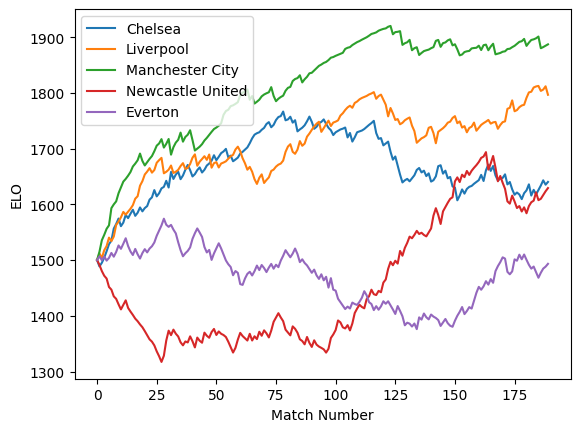

In [46]:
#visualisation of ELO over time
import matplotlib.pyplot as plt
dates = []
Arsenal_ELO = []
Chelsea_ELO = []
ManUtd_ELO = []
Liverpool_ELO = []
ManCity_ELO = []
Newcastle_ELO = []
Brighton_ELO = []
Everton_ELO = []

for idx, row in ELO_match_results_xg.iterrows():
        
        if row["home_team"] == "Arsenal":
            Arsenal_ELO.append(row["home_elo"])
        elif row["away_team"] == "Arsenal":
            Arsenal_ELO.append(row["away_elo"])
        
        if row["home_team"] == "Chelsea":
            Chelsea_ELO.append(row["home_elo"])
        elif row["away_team"] == "Chelsea":
            Chelsea_ELO.append(row["away_elo"])
            
        if row["home_team"] == "Manchester United":
            ManUtd_ELO.append(row["home_elo"])
        elif row["away_team"] == "Manchester United":
            ManUtd_ELO.append(row["away_elo"])
        if row["home_team"] == "Liverpool":
            Liverpool_ELO.append(row["home_elo"])
        elif row["away_team"] == "Liverpool":
            Liverpool_ELO.append(row["away_elo"])
        if row["home_team"] == "Manchester City":
            ManCity_ELO.append(row["home_elo"])
        elif row["away_team"] == "Manchester City":
            ManCity_ELO.append(row["away_elo"])
        if row["home_team"] == "Newcastle United":
            Newcastle_ELO.append(row["home_elo"])
        elif row["away_team"] == "Newcastle United":
            Newcastle_ELO.append(row["away_elo"])
        if row["home_team"] == "Brighton":
            Brighton_ELO.append(row["home_elo"])
        elif row["away_team"] == "Brighton":
            Brighton_ELO.append(row["away_elo"])
            
        if row["home_team"] == "Everton":
            Everton_ELO.append(row["home_elo"])
        elif row["away_team"] == "Everton":
            Everton_ELO.append(row["away_elo"])


plt.plot(Chelsea_ELO, label = "Chelsea")
plt.plot(Liverpool_ELO, label = "Liverpool")
plt.plot(ManCity_ELO, label = "Manchester City")
plt.plot(Newcastle_ELO, label = "Newcastle United")
plt.plot(Everton_ELO, label = "Everton")
plt.xlabel("Match Number")
plt.ylabel("ELO")
plt.legend()

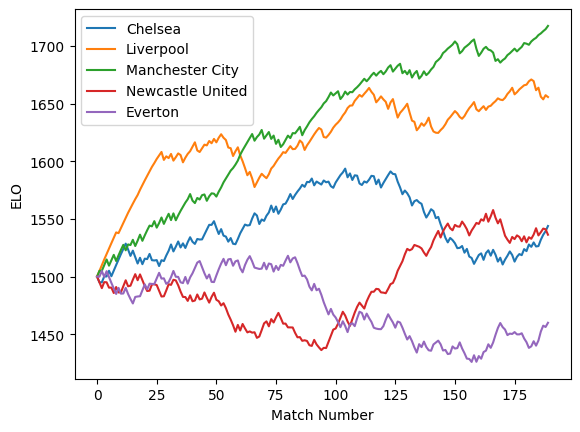

In [47]:
#visualisation of ELO over time
import matplotlib.pyplot as plt
dates = []
Arsenal_ELO = []
Chelsea_ELO = []
ManUtd_ELO = []
Liverpool_ELO = []
ManCity_ELO = []
Newcastle_ELO = []
Brighton_ELO = []
Everton_ELO = []

for idx, row in ELO_match_results.iterrows():
        
        if row["home_team"] == "Arsenal":
            Arsenal_ELO.append(row["home_elo"])
        elif row["away_team"] == "Arsenal":
            Arsenal_ELO.append(row["away_elo"])
        
        if row["home_team"] == "Chelsea":
            Chelsea_ELO.append(row["home_elo"])
        elif row["away_team"] == "Chelsea":
            Chelsea_ELO.append(row["away_elo"])
            
        if row["home_team"] == "Manchester United":
            ManUtd_ELO.append(row["home_elo"])
        elif row["away_team"] == "Manchester United":
            ManUtd_ELO.append(row["away_elo"])
        if row["home_team"] == "Liverpool":
            Liverpool_ELO.append(row["home_elo"])
        elif row["away_team"] == "Liverpool":
            Liverpool_ELO.append(row["away_elo"])
        if row["home_team"] == "Manchester City":
            ManCity_ELO.append(row["home_elo"])
        elif row["away_team"] == "Manchester City":
            ManCity_ELO.append(row["away_elo"])
        if row["home_team"] == "Newcastle United":
            Newcastle_ELO.append(row["home_elo"])
        elif row["away_team"] == "Newcastle United":
            Newcastle_ELO.append(row["away_elo"])
        if row["home_team"] == "Brighton":
            Brighton_ELO.append(row["home_elo"])
        elif row["away_team"] == "Brighton":
            Brighton_ELO.append(row["away_elo"])
            
        if row["home_team"] == "Everton":
            Everton_ELO.append(row["home_elo"])
        elif row["away_team"] == "Everton":
            Everton_ELO.append(row["away_elo"])


plt.plot(Chelsea_ELO, label = "Chelsea")
plt.plot(Liverpool_ELO, label = "Liverpool")
plt.plot(ManCity_ELO, label = "Manchester City")
plt.plot(Newcastle_ELO, label = "Newcastle United")
plt.plot(Everton_ELO, label = "Everton")
plt.xlabel("Match Number")
plt.ylabel("ELO")
plt.legend()
        

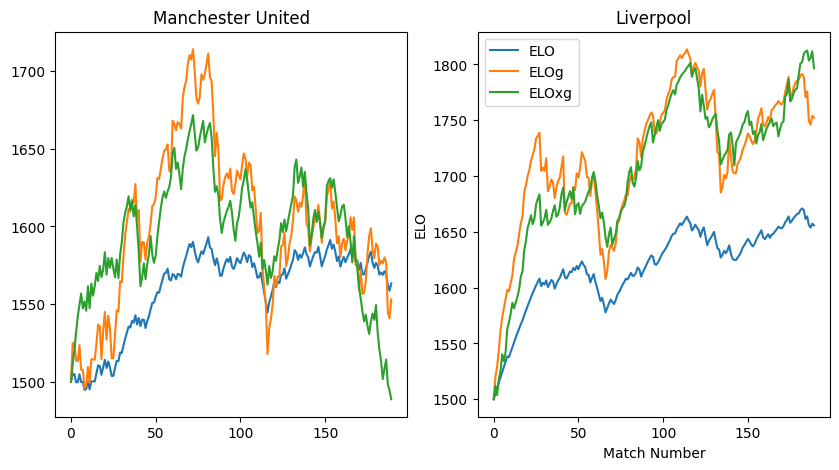

In [48]:
ManUtd_ELOg = []
ManUtd_ELOxg = []

club = "Manchester United"

for idx, row in ELO_match_results_g.iterrows():
        
        if row["home_team"] == club:
            ManUtd_ELOg.append(row["home_elo"])
        elif row["away_team"] == club:
            ManUtd_ELOg.append(row["away_elo"])
            
for idx, row in ELO_match_results_xg.iterrows():
        
        if row["home_team"] == club:
            ManUtd_ELOxg.append(row["home_elo"])
        elif row["away_team"] == club:
            ManUtd_ELOxg.append(row["away_elo"])
            
ManCity_ELOg = []
ManCity_ELOxg = []

club = "Liverpool"

for idx, row in ELO_match_results_g.iterrows():
        
        if row["home_team"] == club:
            ManCity_ELOg.append(row["home_elo"])
        elif row["away_team"] == club:
            ManCity_ELOg.append(row["away_elo"])
            
for idx, row in ELO_match_results_xg.iterrows():
        
        if row["home_team"] == club:
            ManCity_ELOxg.append(row["home_elo"])
        elif row["away_team"] == club:
            ManCity_ELOxg.append(row["away_elo"])

fig, axs = plt.subplots(ncols = 2, figsize = (10, 5))
axs[0].plot(ManUtd_ELO, label = "ELO")
axs[0].plot(ManUtd_ELOg, label = "ELOg")
axs[0].plot(ManUtd_ELOxg, label = "ELOxg")
axs[0].set_title('Manchester United')
axs[1].plot(Liverpool_ELO, label = "ELO")
axs[1].plot(ManCity_ELOg, label = "ELOg")
axs[1].plot(ManCity_ELOxg, label = "ELOxg")
axs[1].set_title('Liverpool')
plt.xlabel("Match Number")
plt.ylabel("ELO")
plt.legend()
plt.show()

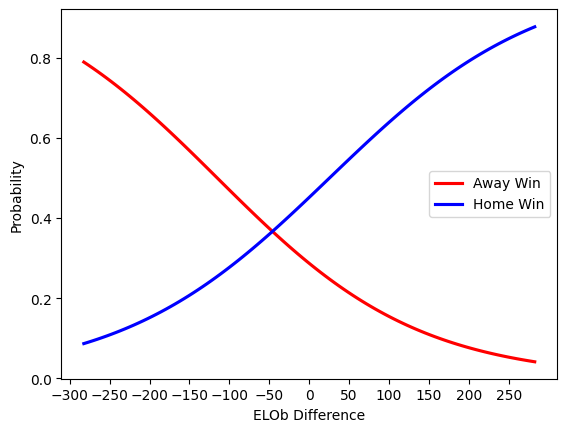

In [49]:
fig, ax = plt.subplots()
sns.regplot(x="elo_diff", y = "away_win", data=training_matches, ci = 0, logistic=True, scatter = False, ax = ax, color  = "red", label = "Away Win", seed = 42)
sns.regplot(x = "elo_diff", y = "home_win", data=training_matches, ci = 0, logistic=True, scatter = False, ax = ax, color = "blue", label = "Home Win", seed = 42)
plt.xlabel("ELOb Difference")
plt.ylabel("Probability")
#set axis ticks
plt.xticks(np.arange(-300, 300, 50))
plt.legend()
plt.show()

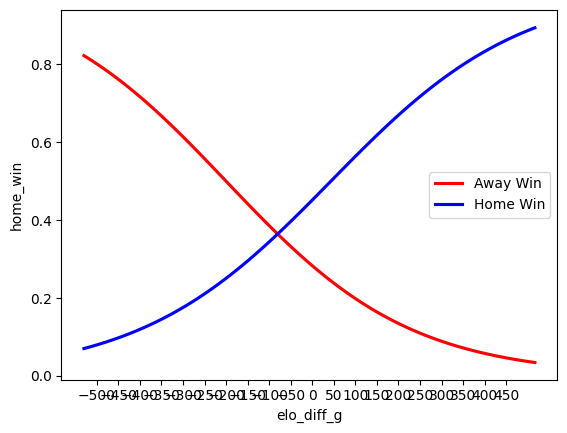

In [50]:
fig, ax = plt.subplots()
sns.regplot(x="elo_diff_g", y = "away_win", data=training_matches_g, ci = 0, logistic=True, scatter = False, ax = ax, color  = "red", label = "Away Win", seed = 42)
sns.regplot(x = "elo_diff_g", y = "home_win", data=training_matches_g, ci = 0, logistic=True, scatter = False, ax = ax, color = "blue", label = "Home Win", seed = 42)
#set axis ticks
plt.xticks(np.arange(-500, 500, 50))
plt.legend()
plt.show()

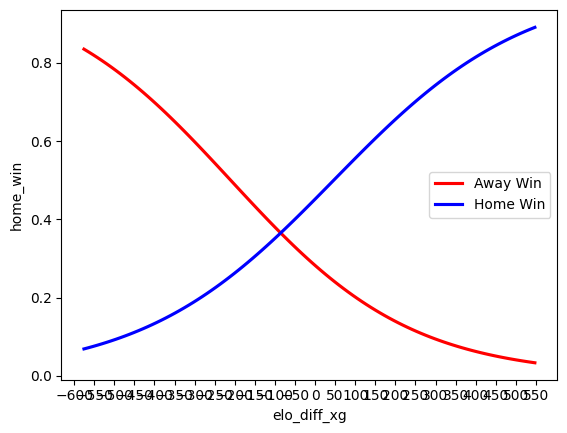

In [51]:
fig, ax = plt.subplots()
sns.regplot(x="elo_diff_xg", y = "away_win", data=training_matches_xg, ci = 0, logistic=True, scatter = False, ax = ax, color  = "red", label = "Away Win", seed = 42)
sns.regplot(x = "elo_diff_xg", y = "home_win", data=training_matches_xg, ci = 0, logistic=True, scatter = False, ax = ax, color = "blue", label = "Home Win", seed = 42)
#set axis ticks
plt.xticks(np.arange(-600, 600, 50))
plt.legend()
plt.show()

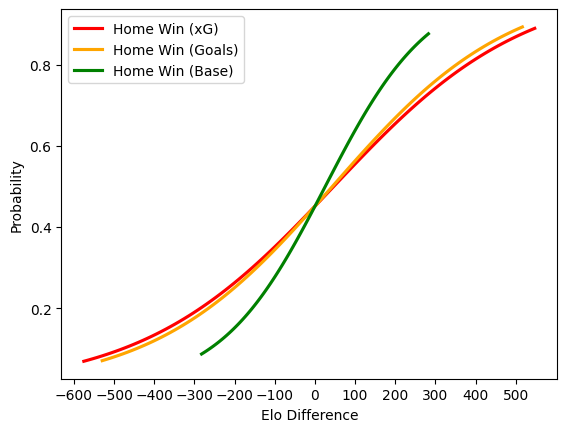

In [52]:
fig, ax = plt.subplots()
sns.regplot(x="elo_diff_xg", y = "home_win", data=training_matches_xg, ci = 0, logistic=True, scatter = False, ax = ax, color  = "red", label = "Home Win (xG)", seed = 42)
sns.regplot(x="elo_diff_g", y = "home_win", data=training_matches_g, ci = 0, logistic=True, scatter = False, ax = ax, color  = "orange", label = "Home Win (Goals)", seed = 42)
sns.regplot(x="elo_diff", y = "home_win", data=training_matches, ci = 0, logistic=True, scatter = False, ax = ax, color  = "green", label = "Home Win (Base)", seed = 42)
plt.xlabel("Elo Difference")
plt.ylabel("Probability")
#set axis ticks
plt.xticks(np.arange(-600, 600, 100))
plt.legend()
plt.show()

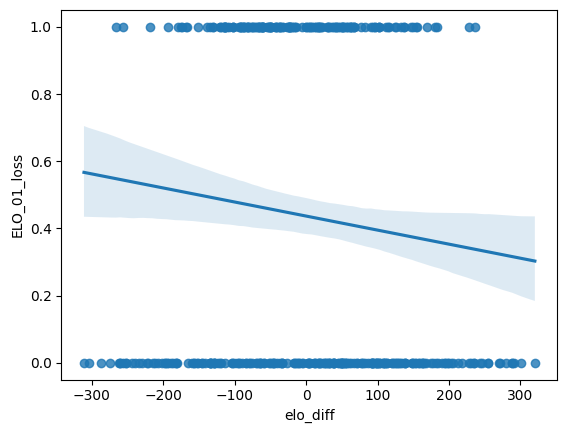

In [53]:
predictions["ELO_01_loss"] = predictions.apply(lambda x: 0 if (x["home_points"] > x["away_points"] and x["home_xPELO"] > x["away_xPELO"]) or (x["home_points"] < x["away_points"] and x["home_xPELO"] < x["away_xPELO"]) else 1, axis = 1)
predictions["ELOg_01_loss"] = predictions.apply(lambda x: 0 if (x["home_points"] > x["away_points"] and x["home_xPELOg"] > x["away_xPELOg"]) or (x["home_points"] < x["away_points"] and x["home_xPELOg"] < x["away_xPELOg"]) else 1, axis = 1)
predictions["ELOxg_01_loss"] = predictions.apply(lambda x: 0 if (x["home_points"] > x["away_points"] and x["home_xPELOxg"] > x["away_xPELOxg"]) or (x["home_points"] < x["away_points"] and x["home_xPELOxg"] < x["away_xPELOxg"]) else 1, axis = 1)

fig, ax = plt.subplots()
sns.regplot(x="elo_diff", y = "ELO_01_loss", data=predictions, logistic = False, ax = ax)
plt.show()

In [54]:
#games where liverpool were at home against manchester united
ELO_match_results_g.sort_values("home_elo", ascending = True).head(10)

,home_team,away_team,home_elo,away_elo,season_end_year
1894,Sheffield United,Tottenham,1221.187942,1562.553693,2024
1870,Sheffield United,Nottingham Forest,1234.176999,1385.932321,2024
956,Norwich,Everton,1244.982177,1434.304034,2022
1139,Norwich,Tottenham,1246.401084,1652.485175,2022
857,Norwich,Leeds,1253.753333,1487.052338,2022
835,Norwich,Brighton,1258.184018,1483.481465,2022
1065,Norwich,Burnley,1258.412690,1399.461301,2022
1110,Norwich,West Ham,1259.330449,1538.418270,2022
1844,Sheffield United,Burnley,1259.363932,1331.715103,2024
1673,Sheffield United,Brentford,1260.030801,1545.206614,2024


In [56]:
print("Base Home Model Intercept:", home_model.intercept_)
print("Base Home Model Slope:", home_model.coef_)
print("Base Away Model Intercept:", away_model.intercept_)
print("Base Away Model Slope:", away_model.coef_)

print("Goals Home Model Intercept:", home_model_g.intercept_)
print("Goals Home Model Slope:", home_model_g.coef_)
print("Goals Away Model Intercept:", away_model_g.intercept_)
print("Goals Away Model Slope:", away_model_g.coef_)

print("xG Home Model Intercept:", home_model_xg.intercept_)
print("xG Home Model Slope:", home_model_xg.coef_)
print("xG Away Model Intercept:", away_model_xg.intercept_)
print("xG Away Model Slope:", away_model_xg.coef_)


Base Home Model Intercept: [-0.19325223]
Base Home Model Slope: [[0.00764348]]
Base Away Model Intercept: [-0.90186476]
Base Away Model Slope: [[-0.00787628]]
Goals Home Model Intercept: [-0.19235785]
Goals Home Model Slope: [[0.00450311]]
Goals Away Model Intercept: [-0.92101631]
Goals Away Model Slope: [[-0.00463354]]
xG Home Model Intercept: [-0.19252948]
xG Home Model Slope: [[0.00418471]]
xG Away Model Intercept: [-0.92480435]
xG Away Model Slope: [[-0.00442372]]


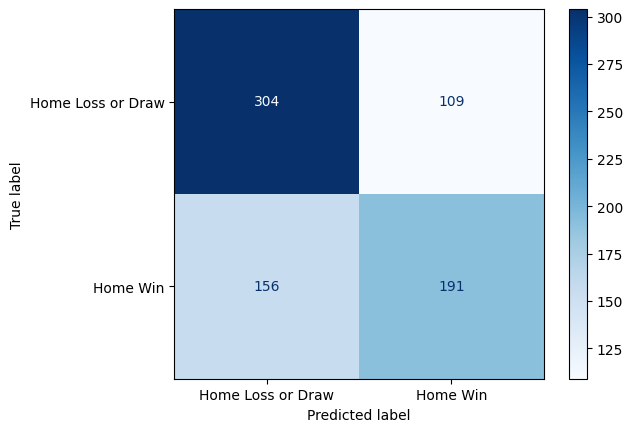

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(home_model, X, y_home, display_labels = ["Home Loss or Draw", "Home Win"], cmap = plt.cm.Blues)

In [58]:
print(training_matches["away_win"].value_counts())
print(training_matches["home_win"].value_counts())

away_win
0    522
1    238
Name: count, dtype: int64
home_win
0    413
1    347
Name: count, dtype: int64


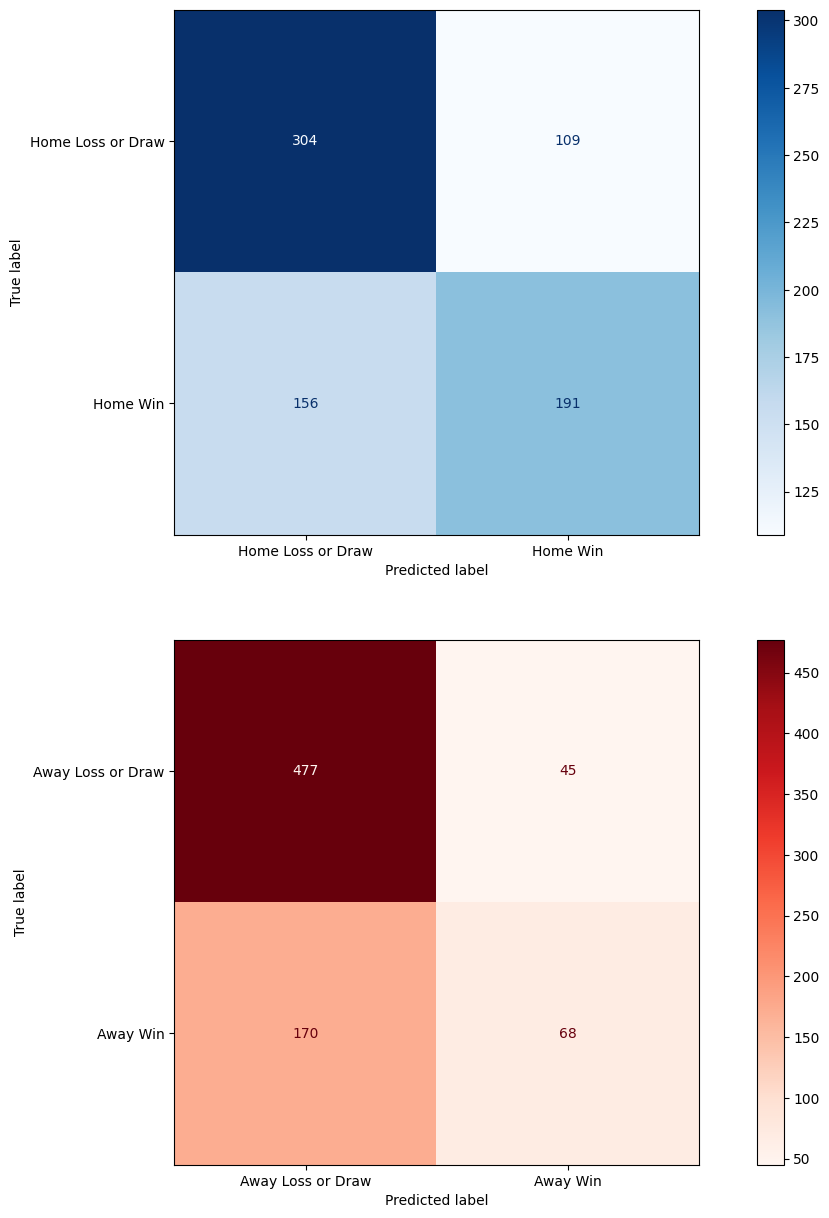

In [59]:
fig, axs = plt.subplots(nrows = 2, figsize = (15, 15))
ConfusionMatrixDisplay.from_estimator(home_model, X, y_home, display_labels = ["Home Loss or Draw", "Home Win"], cmap = plt.cm.Blues, ax = axs[0])
ConfusionMatrixDisplay.from_estimator(away_model, X, y_away, display_labels = ["Away Loss or Draw", "Away Win"], cmap = plt.cm.Reds, ax = axs[1])

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

print("Base Home Model")
print("Accuracy:", accuracy_score(y_home, home_model.predict(X)))
print("Balanced Accuracy:", balanced_accuracy_score(y_home, home_model.predict(X)))
print("Precision:", precision_score(y_home, home_model.predict(X)))
print("Recall:", recall_score(y_home, home_model.predict(X)))
print("F1 Score:", f1_score(y_home, home_model.predict(X)))

print("Base Away Model")
print("Accuracy:", accuracy_score(y_away, away_model.predict(X)))
print("Balanced Accuracy:", balanced_accuracy_score(y_away, away_model.predict(X)))
print("Precision:", precision_score(y_away, away_model.predict(X)))
print("Recall:", recall_score(y_away, away_model.predict(X)))
print("F1 Score:", f1_score(y_away, away_model.predict(X)))

Base Home Model
Accuracy: 0.6513157894736842
Balanced Accuracy: 0.6432548792486271
Precision: 0.6366666666666667
Recall: 0.5504322766570605
F1 Score: 0.5904173106646059
Base Away Model
Accuracy: 0.7171052631578947
Balanced Accuracy: 0.5997536945812808
Precision: 0.6017699115044248
Recall: 0.2857142857142857
F1 Score: 0.38746438746438744


In [61]:
print("Goals Home Model")
print("Accuracy:", accuracy_score(y_home_g, home_model_g.predict(X)))
print("Balanced Accuracy:", balanced_accuracy_score(y_home_g, home_model_g.predict(X)))
print("Precision:", precision_score(y_home_g, home_model_g.predict(X)))
print("Recall:", recall_score(y_home_g, home_model_g.predict(X)))
print("F1 Score:", f1_score(y_home_g, home_model_g.predict(X)))

print("Goals Away Model")
print("Accuracy:", accuracy_score(y_away_g, away_model_g.predict(X)))
print("Balanced Accuracy:", balanced_accuracy_score(y_away_g, away_model_g.predict(X)))
print("Precision:", precision_score(y_away_g, away_model_g.predict(X)))
print("Recall:", recall_score(y_away_g, away_model_g.predict(X)))
print("F1 Score:", f1_score(y_away_g, away_model_g.predict(X)))

Goals Home Model
Accuracy: 0.65
Balanced Accuracy: 0.6372085883149234
Precision: 0.6563706563706564
Recall: 0.4899135446685879
F1 Score: 0.5610561056105611
Goals Away Model
Accuracy: 0.6894736842105263
Balanced Accuracy: 0.5179175118323192
Precision: 0.5384615384615384
Recall: 0.058823529411764705
F1 Score: 0.10606060606060606


In [62]:
print("xG Home Model")
print("Accuracy:", accuracy_score(y_home_xg, home_model_xg.predict(X)))
print("Balanced Accuracy:", balanced_accuracy_score(y_home_xg, home_model_xg.predict(X)))
print("Precision:", precision_score(y_home_xg, home_model_xg.predict(X)))
print("Recall:", recall_score(y_home_xg, home_model_xg.predict(X)))
print("F1 Score:", f1_score(y_home_xg, home_model_xg.predict(X)))

print("xG Away Model")
print("Accuracy:", accuracy_score(y_away_xg, away_model_xg.predict(X)))
print("Balanced Accuracy:", balanced_accuracy_score(y_away_xg, away_model_xg.predict(X)))
print("Precision:", precision_score(y_away_xg, away_model_xg.predict(X)))
print("Recall:", recall_score(y_away_xg, away_model_xg.predict(X)))
print("F1 Score:", f1_score(y_away_xg, away_model_xg.predict(X)))

xG Home Model
Accuracy: 0.6526315789473685
Balanced Accuracy: 0.6389390905094514
Precision: 0.6653386454183267
Recall: 0.4812680115273775
F1 Score: 0.5585284280936454
xG Away Model
Accuracy: 0.6907894736842105
Balanced Accuracy: 0.5143034225184326
Precision: 0.5882352941176471
Recall: 0.04201680672268908
F1 Score: 0.0784313725490196


In [63]:
print(away_model.intercept_, away_model.coef_)
print(away_model_xg.intercept_, away_model_xg.coef_)
print(away_model_g.intercept_, away_model_g.coef_)
print(home_model_xg.intercept_, home_model_xg.coef_)
print(home_model.intercept_, home_model.coef_)
print(home_model_g.intercept_, home_model_g.coef_)

[-0.90186476] [[-0.00787628]]
[-0.92480435] [[-0.00442372]]
[-0.92101631] [[-0.00463354]]
[-0.19252948] [[0.00418471]]
[-0.19325223] [[0.00764348]]
[-0.19235785] [[0.00450311]]


In [64]:
training_matches["home_win"].value_counts()

home_win
0    413
1    347
Name: count, dtype: int64

In [65]:
#games where ELOb was right and odds_AVG was wrong
predictions[((predictions["home_points"] > predictions["away_points"]) & (predictions["home_xPELO"] > predictions["away_xPELO"]) & (predictions["home_xPAVG"] < predictions["away_xPAVG"])) | ((predictions["home_points"] < predictions["away_points"]) & (predictions["home_xPELO"] < predictions["away_xPELO"]) & (predictions["home_xPAVG"] > predictions["away_xPAVG"]))]

,home_team,away_team,home_points,away_points,elo_diff,home_xPELO,away_xPELO,elo_diff_g,home_xPELOg,away_xPELOg,...,ELOg_home_loss,ELOg_away_loss,ELOxg_loss,ELOxg_home_loss,ELOxg_away_loss,odds_MAX_loss,odds_AVG_loss,ELO_01_loss,ELOg_01_loss,ELOxg_01_loss
14,Tottenham,Manchester United,3,0,-45.232947,1.369959,1.365350,-64.799888,1.475242,1.256304,...,2.324888,1.578301,3.850237,2.295163,1.555074,5.161509,5.156951,0,0,0
28,Newcastle United,Liverpool,0,3,-94.533046,1.110866,1.635702,-69.099223,1.318905,1.412866,...,1.739509,2.518994,4.366950,1.790630,2.576320,5.686524,5.671203,0,0,0
65,Aston Villa,Brighton,3,0,-14.671515,1.535517,1.201685,-33.108985,1.572705,1.161842,...,2.037170,1.349877,3.367409,2.026765,1.340645,4.529717,4.543500,0,0,0
142,Manchester United,Chelsea,3,0,56.774602,1.913746,0.852169,68.040841,1.797323,0.952817,...,1.446432,0.907860,2.394159,1.471989,0.922170,4.898577,5.040629,0,0,0
178,Manchester United,Aston Villa,3,0,28.427293,1.767072,0.983879,-96.794531,1.709138,1.033481,...,1.666326,1.068084,2.753901,1.679321,1.074581,4.584074,4.560437,0,0,0
297,Nottingham Forest,Fulham,3,0,-44.892584,1.371793,1.363500,-122.358572,1.476327,1.255239,...,2.321579,1.575626,3.844647,2.292080,1.552567,4.633045,4.648818,0,0,0
306,Fulham,Newcastle United,0,3,-94.472634,1.111173,1.635371,-102.576021,1.319094,1.412672,...,1.740010,2.519610,4.368018,1.791109,2.576909,5.299030,5.121855,0,0,0
317,Newcastle United,Tottenham,3,0,-33.324081,1.434306,1.300922,-18.111441,1.513230,1.219205,...,2.210484,1.486461,3.657485,2.188523,1.468962,5.231365,5.097026,0,0,0
369,Manchester United,Newcastle United,3,0,17.513575,1.709128,1.037217,-75.283203,1.674799,1.065374,...,1.756158,1.135022,2.901679,1.763698,1.137981,5.137570,5.071452,0,0,0
378,Brighton,Manchester United,0,3,-64.923303,1.264698,1.473043,-52.552057,1.412541,1.318336,...,1.995272,2.827993,4.905023,2.034001,2.871021,5.591502,5.639888,0,1,1


In [66]:
#games where ELOg was right and odds_AVG was wrong
predictions[((predictions["home_points"] > predictions["away_points"]) & (predictions["home_xPELOg"] > predictions["away_xPELOg"]) & (predictions["home_xPAVG"] < predictions["away_xPAVG"])) | ((predictions["home_points"] < predictions["away_points"]) & (predictions["home_xPELOg"] < predictions["away_xPELOg"]) & (predictions["home_xPAVG"] > predictions["away_xPAVG"]))]

,home_team,away_team,home_points,away_points,elo_diff,home_xPELO,away_xPELO,elo_diff_g,home_xPELOg,away_xPELOg,...,ELOg_home_loss,ELOg_away_loss,ELOxg_loss,ELOxg_home_loss,ELOxg_away_loss,odds_MAX_loss,odds_AVG_loss,ELO_01_loss,ELOg_01_loss,ELOxg_01_loss
14,Tottenham,Manchester United,3,0,-45.232947,1.369959,1.365350,-64.799888,1.475242,1.256304,...,2.324888,1.578301,3.850237,2.295163,1.555074,5.161509,5.156951,0,0,0
17,West Ham,Chelsea,3,0,-54.507927,1.320158,1.415942,-44.504438,1.445681,1.285425,...,2.415908,1.652318,4.004342,2.379951,1.624392,6.658845,6.601853,1,0,0
28,Newcastle United,Liverpool,0,3,-94.533046,1.110866,1.635702,-69.099223,1.318905,1.412866,...,1.739509,2.518994,4.366950,1.790630,2.576320,5.686524,5.671203,0,0,0
65,Aston Villa,Brighton,3,0,-14.671515,1.535517,1.201685,-33.108985,1.572705,1.161842,...,2.037170,1.349877,3.367409,2.026765,1.340645,4.529717,4.543500,0,0,0
105,Sheffield United,Wolverhampton Wanderers,3,0,-74.238581,1.215619,1.524250,-155.819513,1.382975,1.347937,...,2.614770,1.816935,4.343441,2.565089,1.778352,7.091382,6.891393,1,0,0
106,Newcastle United,Arsenal,3,0,-73.702269,1.218429,1.521300,-64.298499,1.384675,1.346229,...,2.609275,1.812333,4.334025,2.559975,1.774051,4.823922,4.857206,1,0,0
142,Manchester United,Chelsea,3,0,56.774602,1.913746,0.852169,68.040841,1.797323,0.952817,...,1.446432,0.907860,2.394159,1.471989,0.922170,4.898577,5.040629,0,0,0
158,Everton,Chelsea,3,0,-69.605381,1.239961,1.498772,-64.955022,1.397670,1.333196,...,2.567460,1.777412,4.262463,2.521053,1.741410,5.456579,5.457138,1,0,0
177,Wolverhampton Wanderers,Chelsea,3,0,-61.021778,1.285407,1.451627,-94.885873,1.424946,1.305984,...,2.480794,1.705593,4.114618,2.440371,1.674246,6.875928,6.814305,1,0,0
178,Manchester United,Aston Villa,3,0,28.427293,1.767072,0.983879,-96.794531,1.709138,1.033481,...,1.666326,1.068084,2.753901,1.679321,1.074581,4.584074,4.560437,0,0,0


In [67]:
#games where ELOxg was right and odds_AVG was wrong
predictions[((predictions["home_points"] > predictions["away_points"]) & (predictions["home_xPELOxg"] > predictions["away_xPELOxg"]) & (predictions["home_xPAVG"] < predictions["away_xPAVG"])) | ((predictions["home_points"] < predictions["away_points"]) & (predictions["home_xPELOxg"] < predictions["away_xPELOxg"]) & (predictions["home_xPAVG"] > predictions["away_xPAVG"]))]

,home_team,away_team,home_points,away_points,elo_diff,home_xPELO,away_xPELO,elo_diff_g,home_xPELOg,away_xPELOg,...,ELOg_home_loss,ELOg_away_loss,ELOxg_loss,ELOxg_home_loss,ELOxg_away_loss,odds_MAX_loss,odds_AVG_loss,ELO_01_loss,ELOg_01_loss,ELOxg_01_loss
14,Tottenham,Manchester United,3,0,-45.232947,1.369959,1.365350,-64.799888,1.475242,1.256304,...,2.324888,1.578301,3.850237,2.295163,1.555074,5.161509,5.156951,0,0,0
17,West Ham,Chelsea,3,0,-54.507927,1.320158,1.415942,-44.504438,1.445681,1.285425,...,2.415908,1.652318,4.004342,2.379951,1.624392,6.658845,6.601853,1,0,0
28,Newcastle United,Liverpool,0,3,-94.533046,1.110866,1.635702,-69.099223,1.318905,1.412866,...,1.739509,2.518994,4.366950,1.790630,2.576320,5.686524,5.671203,0,0,0
65,Aston Villa,Brighton,3,0,-14.671515,1.535517,1.201685,-33.108985,1.572705,1.161842,...,2.037170,1.349877,3.367409,2.026765,1.340645,4.529717,4.543500,0,0,0
79,Arsenal,Manchester City,3,0,-82.272722,1.173762,1.568429,-139.605341,1.357547,1.373577,...,2.697651,1.886713,4.485773,2.642229,1.843544,5.194931,5.140631,1,1,0
105,Sheffield United,Wolverhampton Wanderers,3,0,-74.238581,1.215619,1.524250,-155.819513,1.382975,1.347937,...,2.614770,1.816935,4.343441,2.565089,1.778352,7.091382,6.891393,1,0,0
106,Newcastle United,Arsenal,3,0,-73.702269,1.218429,1.521300,-64.298499,1.384675,1.346229,...,2.609275,1.812333,4.334025,2.559975,1.774051,4.823922,4.857206,1,0,0
122,Luton,Crystal Palace,3,0,-83.094573,1.169507,1.572946,-108.369517,1.354951,1.376205,...,2.706188,1.893939,4.500468,2.650174,1.850294,6.480569,6.374270,1,1,0
142,Manchester United,Chelsea,3,0,56.774602,1.913746,0.852169,68.040841,1.797323,0.952817,...,1.446432,0.907860,2.394159,1.471989,0.922170,4.898577,5.040629,0,0,0
158,Everton,Chelsea,3,0,-69.605381,1.239961,1.498772,-64.955022,1.397670,1.333196,...,2.567460,1.777412,4.262463,2.521053,1.741410,5.456579,5.457138,1,0,0


In [68]:
#games where ELOb was wrong and odds_AVG was right
predictions[((predictions["home_points"] < predictions["away_points"]) & (predictions["home_xPELO"] > predictions["away_xPELO"]) & (predictions["home_xPAVG"] < predictions["away_xPAVG"])) | ((predictions["home_points"] > predictions["away_points"]) & (predictions["home_xPELO"] < predictions["away_xPELO"]) & (predictions["home_xPAVG"] > predictions["away_xPAVG"]))]

,home_team,away_team,home_points,away_points,elo_diff,home_xPELO,away_xPELO,elo_diff_g,home_xPELOg,away_xPELOg,...,ELOg_home_loss,ELOg_away_loss,ELOxg_loss,ELOxg_home_loss,ELOxg_away_loss,odds_MAX_loss,odds_AVG_loss,ELO_01_loss,ELOg_01_loss,ELOxg_01_loss
69,Luton,Burnley,0,3,-34.154466,1.429809,1.305391,6.448460,1.510581,1.221780,...,2.281855,3.162065,5.493013,2.304783,3.188230,4.243214,4.224245,1,1,1
121,Sheffield United,Bournemouth,0,3,-24.319474,1.483141,1.252722,-65.877077,1.541954,1.191392,...,2.377622,3.271062,5.686392,2.394910,3.291482,3.241278,3.343203,1,1,1
133,Nottingham Forest,Everton,0,3,-26.580315,1.470872,1.264776,-5.724509,1.534744,1.198355,...,2.355438,3.245925,5.641725,2.374046,3.267679,4.278347,4.331040,1,1,1
159,Fulham,West Ham,3,0,-53.785548,1.324024,1.411992,-35.394277,1.447982,1.283150,...,2.408760,1.646475,3.992216,2.373294,1.618922,3.834289,3.878955,1,0,0
174,Nottingham Forest,Bournemouth,0,3,-40.611628,1.394885,1.340267,-63.828801,1.489981,1.241867,...,2.220043,3.091032,5.367407,2.246524,3.120883,4.337578,4.270936,1,1,1
186,Brighton,Tottenham,3,0,-50.797044,1.340042,1.395665,-46.048688,1.457504,1.273752,...,2.379295,1.622443,3.942271,2.345849,1.596422,4.361047,4.463843,1,0,0
226,Arsenal,Liverpool,3,0,-48.676367,1.351431,1.384097,-82.084702,1.464263,1.267094,...,2.358488,1.605527,3.907046,2.326468,1.580579,3.503040,3.567787,1,0,0
242,Nottingham Forest,West Ham,3,0,-87.888380,1.144798,1.599276,-107.568037,1.339821,1.391550,...,2.756193,1.936413,4.586674,2.696715,1.889959,3.942136,3.979419,1,1,1
261,Fulham,Brighton,3,0,-79.378050,1.188788,1.552515,-84.741113,1.366700,1.364328,...,2.667668,1.861392,4.434214,2.614324,1.819890,4.458898,4.496637,1,0,0
265,Burnley,Bournemouth,0,3,-44.166258,1.375707,1.359552,-103.627753,1.478643,1.252968,...,2.186386,3.052122,5.298741,2.214770,3.083971,2.655653,2.691123,1,1,1


In [69]:
squads = []
correct = []

for team in combined_results["Squad"]:
    correct_games = []
    team_predictions = predictions[(predictions["home_team"] == team) | (predictions["away_team"] == team)]
    for idx, row in team_predictions.iterrows():
        if (row["home_points"] > row["away_points"] and row["home_xPELO"] > row["away_xPELO"]) or (row["home_points"] < row["away_points"] and row["home_xPELO"] < row["away_xPELO"]):
            correct_games.append(1)
        else:
            correct_games.append(0)
    
    squads.append(team)
    correct.append(sum(correct_games))
            

correct_count = pd.DataFrame({"Squad": squads, "Correct": correct})         
correct_count.sort_values("Correct", ascending = False)

,Squad,Correct
0,Manchester City,28
1,Arsenal,26
6,Newcastle United,25
19,Sheffield United,24
2,Liverpool,24
4,Tottenham,23
7,Manchester United,23
18,Burnley,23
13,Fulham,22
15,Brentford,22


In [70]:
squads = []
correct = []

for team in combined_results["Squad"]:
    correct_games = []
    team_predictions = predictions[(predictions["home_team"] == team) | (predictions["away_team"] == team)]
    for idx, row in team_predictions.iterrows():
        if (row["home_points"] > row["away_points"] and row["home_xPELOg"] > row["away_xPELOg"]) or (row["home_points"] < row["away_points"] and row["home_xPELOg"] < row["away_xPELOg"]):
            correct_games.append(1)
        else:
            correct_games.append(0)
    
    squads.append(team)
    correct.append(sum(correct_games))
            

correct_countg = pd.DataFrame({"Squad": squads, "Correctg": correct})         
correct_countg.sort_values("Correctg", ascending = False)

,Squad,Correctg
0,Manchester City,28
1,Arsenal,27
6,Newcastle United,25
2,Liverpool,25
19,Sheffield United,24
4,Tottenham,23
7,Manchester United,23
5,Chelsea,21
13,Fulham,21
17,Luton,21


In [71]:
squads = []
correct = []

for team in combined_results["Squad"]:
    correct_games = []
    team_predictions = predictions[(predictions["home_team"] == team) | (predictions["away_team"] == team)]
    for idx, row in team_predictions.iterrows():
        if (row["home_points"] > row["away_points"] and row["home_xPELOxg"] > row["away_xPELOxg"]) or (row["home_points"] < row["away_points"] and row["home_xPELOxg"] < row["away_xPELOxg"]):
            correct_games.append(1)
        else:
            correct_games.append(0)
    
    squads.append(team)
    correct.append(sum(correct_games))
            

correct_countxg = pd.DataFrame({"Squad": squads, "Correctxg": correct})         
correct_countxg.sort_values("Correctxg", ascending = False)

,Squad,Correctxg
0,Manchester City,29
1,Arsenal,27
6,Newcastle United,25
2,Liverpool,25
19,Sheffield United,24
4,Tottenham,23
7,Manchester United,22
17,Luton,22
13,Fulham,21
5,Chelsea,20


In [72]:
squads = []
correct = []

for team in combined_results["Squad"]:
    correct_games = []
    team_predictions = predictions[(predictions["home_team"] == team) | (predictions["away_team"] == team)]
    for idx, row in team_predictions.iterrows():
        if (row["home_points"] > row["away_points"] and row["home_xPAVG"] > row["away_xPAVG"]) or (row["home_points"] < row["away_points"] and row["home_xPAVG"] < row["away_xPAVG"]):
            correct_games.append(1)
        else:
            correct_games.append(0)
    
    squads.append(team)
    correct.append(sum(correct_games))
            

correct_countAVG = pd.DataFrame({"Squad": squads, "CorrectAVG": correct})         
correct_countAVG.sort_values("CorrectAVG", ascending = False)

,Squad,CorrectAVG
0,Manchester City,28
1,Arsenal,27
18,Burnley,27
19,Sheffield United,27
16,Nottingham Forest,24
2,Liverpool,24
12,Bournemouth,23
17,Luton,23
4,Tottenham,22
9,Crystal Palace,22


In [73]:
correct_count_all = pd.merge(correct_count, correct_countg, on = "Squad")
correct_count_all = pd.merge(correct_count_all, correct_countxg, on = "Squad")
correct_count_all = pd.merge(correct_count_all, correct_countAVG, on = "Squad")

correct_count_all

,Squad,Correct,Correctg,Correctxg,CorrectAVG
0,Manchester City,28,28,29,28
1,Arsenal,26,27,27,27
2,Liverpool,24,25,25,24
3,Aston Villa,19,19,19,18
4,Tottenham,23,23,23,22
5,Chelsea,19,21,20,20
6,Newcastle United,25,25,25,20
7,Manchester United,23,23,22,20
8,West Ham,17,18,18,19
9,Crystal Palace,19,17,18,22


In [74]:
#how many of the games that the model predicted incorrectly were games played by middle 8 teams
predictions["Mid8"] = predictions["home_team"].isin(mid8) | predictions["away_team"].isin(mid8)
predictions["Top6"] = predictions["home_team"].isin(top6) | predictions["away_team"].isin(top6)
predictions["Bottom6"] = predictions["home_team"].isin(bottom6) | predictions["away_team"].isin(bottom6)
predictions["United"] = predictions["home_team"].isin(["Manchester United"]) | predictions["away_team"].isin(["Manchester United"])

#games that ELO got wrong
wrong_ELO = predictions[((predictions["home_points"] > predictions["away_points"]) & (predictions["home_xPELO"] < predictions["away_xPELO"])) | ((predictions["home_points"] < predictions["away_points"]) & (predictions["home_xPELO"] > predictions["away_xPELO"]))]
wrong_ELO["Mid8"].value_counts()

Mid8
True     55
False    29
Name: count, dtype: int64

In [75]:
wrong_ELO[wrong_ELO["United"] == True]

,home_team,away_team,home_points,away_points,elo_diff,home_xPELO,away_xPELO,elo_diff_g,home_xPELOg,away_xPELOg,...,ELOxg_away_loss,odds_MAX_loss,odds_AVG_loss,ELO_01_loss,ELOg_01_loss,ELOxg_01_loss,Mid8,Top6,Bottom6,United
39,Manchester United,Brighton,0,3,63.608360,1.948068,0.822010,8.241876,1.818318,0.933869,...,4.233936,5.598032,5.574281,1,1,1,True,False,False,True
63,Manchester United,Crystal Palace,0,3,111.879672,2.175448,0.628165,122.908298,1.962842,0.806033,...,4.748355,9.536311,9.479850,1,1,1,True,False,False,True
152,Manchester United,Bournemouth,0,3,150.354542,2.334177,0.498594,205.923965,2.072193,0.712189,...,5.146889,9.644765,9.436657,1,1,1,True,False,False,True
171,West Ham,Manchester United,3,0,-93.512327,1.116054,1.630113,-92.375233,1.322113,1.409589,...,1.937133,4.558942,4.547324,1,1,1,True,False,False,True
191,Nottingham Forest,Manchester United,3,0,-173.689853,0.744198,2.049615,-188.523600,1.076990,1.667973,...,2.679272,6.071509,5.996057,1,1,1,True,False,True,True
236,Aston Villa,Manchester United,0,3,-38.123998,1.408328,1.326806,49.866739,1.497917,1.234116,...,3.146784,5.896212,5.812838,1,1,1,True,True,False,True
252,Manchester United,Fulham,0,3,154.242735,2.348993,0.486726,140.905806,2.082909,0.703121,...,5.186374,9.236179,9.179084,1,1,1,True,False,False,True
302,Chelsea,Manchester United,3,0,-52.638772,1.330166,1.405723,-65.375507,1.451635,1.279542,...,1.610264,2.910315,3.018520,1,0,0,True,True,False,True
356,Crystal Palace,Manchester United,3,0,-107.682718,1.044917,1.707399,-104.228155,1.277721,1.455174,...,2.059011,3.951813,4.016132,1,1,1,True,False,False,True
